In [1]:
import matplotlib.pyplot as plt

import Framework.Confounder_Injection as CI
import Framework.Models as Models
import importlib
importlib.reload(Models)
importlib.reload(CI)
import torch
import pandas as pd
import numpy as np
import seaborn as sbs
import matplotlib.pyplot as plt
import time
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from torch import nn
from ray.tune import CLIReporter
import wandb
import datetime


In [2]:
params = [
    [[1, 4], [3, 6]], # real feature
    [[10, 12], [20, 22]] # confounder
]

# De-correlated confounders in target- and test-data

In [3]:
e = datetime.datetime.now()

search_space = {
    "model":None,
    "device":"cuda",
    "loss_fn":nn.CrossEntropyLoss(),
    "epochs":500,
    "batch_size": tune.choice([32,64,128,256]),
    "optimizer":torch.optim.Adam,

    "alpha":tune.uniform(0,1),
    "lr": tune.loguniform(1e-5,1e-1),
    "weight_decay": tune.loguniform(1e-5,1e-1),
    "wandb": {
        "api_key": "10dd47062950e00af63d29317ead0331316732ff",
        "entity": "confounder_in_ml",
        "project": "Hyperparameters",
        "tags": [f"{e}"]
    },
}
max_t = 500
samples = 30
target_domain_samples = 16


In [4]:
def plot_analysis(analysis):
    dfs = analysis.trial_dataframes
    ax = None  # This plots everything on the same plot
    for d in dfs.values():
        ax = d.mean_accuracy.plot(ax=ax, legend=False)

# BrNet

In [5]:
c = CI.confounder()
model = Models.Br_Net()
search_space["model"] = model
search_space["wandb"]["group"] = "BrNet"

c.generate_data(mode="br_net", samples=512, overlap=0, target_domain_samples=target_domain_samples, target_domain_confounding=1, train_confounding=1, test_confounding=[1], de_correlate_confounder_target=True, de_correlate_confounder_test=True, params=params)

reporter = CLIReporter(max_progress_rows=1, max_report_frequency=120)
analysis = tune.run(c.train_tune,num_samples=samples, progress_reporter=reporter, config=search_space, scheduler=ASHAScheduler(metric="mean_accuracy", mode="max", max_t=max_t))

2022-07-15 12:48:39,722	INFO registry.py:91 -- Detected unknown callable for trainable. Converting to class.
2022-07-15 12:48:39,724	WARNING function_runner.py:603 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2022-07-15 12:48:42,414	WARNING worker.py:1404 -- Warning: The actor ImplicitFunc is very large (16 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
(ImplicitFunc pid=4071400) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin


== Status ==
Current time: 2022-07-15 12:48:52 (running for 00:00:12.12)
Memory usage on this node: 21.3/30.5 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 256.000: None | Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/7.03 GiB heap, 0.0/3.52 GiB objects
Result logdir: /home/raffi/ray_results/train_tune_2022-07-15_12-48-40
Number of trials: 17/30 (16 PENDING, 1 RUNNING)
+------------------------+----------+------------------------+----------+--------------+-----------+----------------+
| Trial name             | status   | loc                    |    alpha |   batch_size |        lr |   weight_decay |
|------------------------+----------+------------------------+----------+--------------+-----------+----------------|
| train_tune_aff68_00000 | RUNNING  | 192.168.178.26:4071400 | 0.281227 |          128 | 0.0441387 |     0.00277457 |
| train_tune_aff68_00001 | PENDING  |                        | 0.45186

(ImplicitFunc pid=4071400) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4071400) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-48-40/train_tune_aff68_00000_0_alpha=0.2812,batch_size=128,lr=0.0441,weight_decay=0.0028_2022-07-15_12-48-42/wandb/run-20220715_124848-aff68_00000
(ImplicitFunc pid=4071400) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=4071400) wandb: Syncing run train_tune_aff68_00000
(ImplicitFunc pid=4071400) wandb: ⭐️ View project at https://wandb.ai/confounder_in_ml/Hyperparameters
(ImplicitFunc pid=4071400) wandb: 🚀 View run at https://wandb.ai/confounder_in_ml/Hyperparameters/runs/aff68_00000


Result for train_tune_aff68_00000:
  date: 2022-07-15_12-48-52
  done: false
  experiment_id: cce9c4752c6e4b99a6d5d56e4e0d730e
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.6162109375
  node_ip: 192.168.178.26
  pid: 4071400
  time_since_restore: 0.2355794906616211
  time_this_iter_s: 0.2355794906616211
  time_total_s: 0.2355794906616211
  timestamp: 1657882132
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: aff68_00000
  warmup_time: 4.807846307754517
  


(ImplicitFunc pid=4071529) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin
(ImplicitFunc pid=4071532) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin


Result for train_tune_aff68_00000:
  date: 2022-07-15_12-49-00
  done: false
  experiment_id: cce9c4752c6e4b99a6d5d56e4e0d730e
  hostname: fedora
  iterations_since_restore: 15
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4071400
  time_since_restore: 8.467172384262085
  time_this_iter_s: 0.3069648742675781
  time_total_s: 8.467172384262085
  timestamp: 1657882140
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: aff68_00000
  warmup_time: 4.807846307754517
  


(ImplicitFunc pid=4071537) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin
(ImplicitFunc pid=4071539) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin
(ImplicitFunc pid=4071545) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin
(ImplicitFunc pid=4071541) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin
(ImplicitFunc pid=4071570) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin
(ImplicitFunc pid=4071572) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin
(ImplicitFunc pid=4071614) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin
(ImplicitFunc pid=4071627) wandb: Currently logg

Result for train_tune_aff68_00000:
  date: 2022-07-15_12-49-05
  done: false
  experiment_id: cce9c4752c6e4b99a6d5d56e4e0d730e
  hostname: fedora
  iterations_since_restore: 36
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4071400
  time_since_restore: 13.50429892539978
  time_this_iter_s: 0.3229515552520752
  time_total_s: 13.50429892539978
  timestamp: 1657882145
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: aff68_00000
  warmup_time: 4.807846307754517
  


(ImplicitFunc pid=4071532) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4071532) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-48-40/train_tune_aff68_00002_2_alpha=0.8288,batch_size=256,lr=0.0454,weight_decay=0.0020_2022-07-15_12-48-52/wandb/run-20220715_124900-aff68_00002
(ImplicitFunc pid=4071532) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=4071532) wandb: Syncing run train_tune_aff68_00002
(ImplicitFunc pid=4071532) wandb: ⭐️ View project at https://wandb.ai/confounder_in_ml/Hyperparameters
(ImplicitFunc pid=4071532) wandb: 🚀 View run at https://wandb.ai/confounder_in_ml/Hyperparameters/runs/aff68_00002
(ImplicitFunc pid=4071529) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4071529) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-48-40/train_tune_aff68_00001_1_alpha=0.4519,batch_size=256,lr=0.0013,weight_decay=0.0000_2022-07-15_12-48-52/wandb/run-

Result for train_tune_aff68_00002:
  date: 2022-07-15_12-49-06
  done: true
  experiment_id: 989afcb83b464131b04dd9cdd3ab05f5
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071532
  time_since_restore: 0.4766061305999756
  time_this_iter_s: 0.4766061305999756
  time_total_s: 0.4766061305999756
  timestamp: 1657882146
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: aff68_00002
  warmup_time: 5.738806486129761
  
Result for train_tune_aff68_00001:
  date: 2022-07-15_12-49-06
  done: true
  experiment_id: 38ad4aa5a2c74ff68fcec0797ad7ae38
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071529
  time_since_restore: 0.4102034568786621
  time_this_iter_s: 0.4102034568786621
  time_total_s: 0.4102034568786621
  timestamp: 1657882146
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: aff68_00001
  warmup_time: 5.991414308547974
  


(ImplicitFunc pid=4071537) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4071537) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-48-40/train_tune_aff68_00003_3_alpha=0.6351,batch_size=256,lr=0.0001,weight_decay=0.0040_2022-07-15_12-48-52/wandb/run-20220715_124900-aff68_00003
(ImplicitFunc pid=4071537) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=4071537) wandb: Syncing run train_tune_aff68_00003
(ImplicitFunc pid=4071537) wandb: ⭐️ View project at https://wandb.ai/confounder_in_ml/Hyperparameters
(ImplicitFunc pid=4071537) wandb: 🚀 View run at https://wandb.ai/confounder_in_ml/Hyperparameters/runs/aff68_00003


Result for train_tune_aff68_00016:
  date: 2022-07-15_12-49-06
  done: true
  experiment_id: 989afcb83b464131b04dd9cdd3ab05f5
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071532
  time_since_restore: 0.43401479721069336
  time_this_iter_s: 0.43401479721069336
  time_total_s: 0.43401479721069336
  timestamp: 1657882146
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: aff68_00016
  warmup_time: 5.738806486129761
  
Result for train_tune_aff68_00017:
  date: 2022-07-15_12-49-06
  done: true
  experiment_id: 38ad4aa5a2c74ff68fcec0797ad7ae38
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071529
  time_since_restore: 0.42619776725769043
  time_this_iter_s: 0.42619776725769043
  time_total_s: 0.42619776725769043
  timestamp: 1657882146
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: aff68_00017
  warmup_time: 5.991414308547974
  
Result for train

(ImplicitFunc pid=4071539) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4071539) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-48-40/train_tune_aff68_00004_4_alpha=0.5425,batch_size=32,lr=0.0000,weight_decay=0.0261_2022-07-15_12-48-52/wandb/run-20220715_124901-aff68_00004
(ImplicitFunc pid=4071539) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=4071539) wandb: Syncing run train_tune_aff68_00004
(ImplicitFunc pid=4071539) wandb: ⭐️ View project at https://wandb.ai/confounder_in_ml/Hyperparameters
(ImplicitFunc pid=4071539) wandb: 🚀 View run at https://wandb.ai/confounder_in_ml/Hyperparameters/runs/aff68_00004


Result for train_tune_aff68_00020:
  date: 2022-07-15_12-49-08
  done: false
  experiment_id: 38ad4aa5a2c74ff68fcec0797ad7ae38
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071529
  time_since_restore: 0.461292028427124
  time_this_iter_s: 0.461292028427124
  time_total_s: 0.461292028427124
  timestamp: 1657882148
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: aff68_00020
  warmup_time: 5.991414308547974
  


(ImplicitFunc pid=4071545) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4071545) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-48-40/train_tune_aff68_00006_6_alpha=0.9238,batch_size=128,lr=0.0001,weight_decay=0.0032_2022-07-15_12-48-53/wandb/run-20220715_124901-aff68_00006
(ImplicitFunc pid=4071545) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=4071545) wandb: Syncing run train_tune_aff68_00006
(ImplicitFunc pid=4071545) wandb: ⭐️ View project at https://wandb.ai/confounder_in_ml/Hyperparameters
(ImplicitFunc pid=4071545) wandb: 🚀 View run at https://wandb.ai/confounder_in_ml/Hyperparameters/runs/aff68_00006


Result for train_tune_aff68_00004:
  date: 2022-07-15_12-49-08
  done: false
  experiment_id: 42447524331b48599c20fde7d0694ebf
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071539
  time_since_restore: 0.6103591918945312
  time_this_iter_s: 0.6103591918945312
  time_total_s: 0.6103591918945312
  timestamp: 1657882148
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: aff68_00004
  warmup_time: 7.114288091659546
  


(ImplicitFunc pid=4071541) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4071541) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-48-40/train_tune_aff68_00005_5_alpha=0.5193,batch_size=64,lr=0.0382,weight_decay=0.0008_2022-07-15_12-48-53/wandb/run-20220715_124902-aff68_00005
(ImplicitFunc pid=4071541) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=4071541) wandb: Syncing run train_tune_aff68_00005
(ImplicitFunc pid=4071541) wandb: ⭐️ View project at https://wandb.ai/confounder_in_ml/Hyperparameters
(ImplicitFunc pid=4071541) wandb: 🚀 View run at https://wandb.ai/confounder_in_ml/Hyperparameters/runs/aff68_00005


Result for train_tune_aff68_00006:
  date: 2022-07-15_12-49-09
  done: false
  experiment_id: 1b54438b4c0b4a2394283458e999ad73
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071545
  time_since_restore: 0.5532739162445068
  time_this_iter_s: 0.5532739162445068
  time_total_s: 0.5532739162445068
  timestamp: 1657882149
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: aff68_00006
  warmup_time: 7.429576635360718
  


(ImplicitFunc pid=4071570) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4071570) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-48-40/train_tune_aff68_00007_7_alpha=0.5286,batch_size=128,lr=0.0015,weight_decay=0.0038_2022-07-15_12-48-53/wandb/run-20220715_124902-aff68_00007
(ImplicitFunc pid=4071570) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=4071570) wandb: Syncing run train_tune_aff68_00007
(ImplicitFunc pid=4071570) wandb: ⭐️ View project at https://wandb.ai/confounder_in_ml/Hyperparameters
(ImplicitFunc pid=4071570) wandb: 🚀 View run at https://wandb.ai/confounder_in_ml/Hyperparameters/runs/aff68_00007


Result for train_tune_aff68_00005:
  date: 2022-07-15_12-49-09
  done: true
  experiment_id: 9c9e0223b1cd4ecebdee50ef32627898
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4071541
  time_since_restore: 0.7657854557037354
  time_this_iter_s: 0.7657854557037354
  time_total_s: 0.7657854557037354
  timestamp: 1657882149
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: aff68_00005
  warmup_time: 7.552311182022095
  


(ImplicitFunc pid=4071628) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4071628) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-48-40/train_tune_aff68_00011_11_alpha=0.8131,batch_size=256,lr=0.0008,weight_decay=0.0101_2022-07-15_12-48-54/wandb/run-20220715_124903-aff68_00011
(ImplicitFunc pid=4071628) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=4071628) wandb: Syncing run train_tune_aff68_00011
(ImplicitFunc pid=4071628) wandb: ⭐️ View project at https://wandb.ai/confounder_in_ml/Hyperparameters
(ImplicitFunc pid=4071628) wandb: 🚀 View run at https://wandb.ai/confounder_in_ml/Hyperparameters/runs/aff68_00011


Result for train_tune_aff68_00007:
  date: 2022-07-15_12-49-10
  done: false
  experiment_id: 5318e68f25064e6c905acee9798fa149
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071570
  time_since_restore: 0.5694761276245117
  time_this_iter_s: 0.5694761276245117
  time_total_s: 0.5694761276245117
  timestamp: 1657882150
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: aff68_00007
  warmup_time: 7.6094019412994385
  


(ImplicitFunc pid=4071572) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4071572) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-48-40/train_tune_aff68_00008_8_alpha=0.5512,batch_size=128,lr=0.0001,weight_decay=0.0001_2022-07-15_12-48-53/wandb/run-20220715_124903-aff68_00008
(ImplicitFunc pid=4071572) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=4071572) wandb: Syncing run train_tune_aff68_00008
(ImplicitFunc pid=4071572) wandb: ⭐️ View project at https://wandb.ai/confounder_in_ml/Hyperparameters
(ImplicitFunc pid=4071572) wandb: 🚀 View run at https://wandb.ai/confounder_in_ml/Hyperparameters/runs/aff68_00008
(ImplicitFunc pid=4071627) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4071627) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-48-40/train_tune_aff68_00010_10_alpha=0.0854,batch_size=32,lr=0.0007,weight_decay=0.0000_2022-07-15_12-48-54/wandb/run-

Result for train_tune_aff68_00021:
  date: 2022-07-15_12-49-10
  done: false
  experiment_id: 9c9e0223b1cd4ecebdee50ef32627898
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071541
  time_since_restore: 0.6549906730651855
  time_this_iter_s: 0.6549906730651855
  time_total_s: 0.6549906730651855
  timestamp: 1657882150
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: aff68_00021
  warmup_time: 7.552311182022095
  


(ImplicitFunc pid=4071694) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4071694) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-48-40/train_tune_aff68_00012_12_alpha=0.3260,batch_size=32,lr=0.0001,weight_decay=0.0916_2022-07-15_12-48-54/wandb/run-20220715_124903-aff68_00012
(ImplicitFunc pid=4071694) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=4071694) wandb: Syncing run train_tune_aff68_00012
(ImplicitFunc pid=4071694) wandb: ⭐️ View project at https://wandb.ai/confounder_in_ml/Hyperparameters
(ImplicitFunc pid=4071694) wandb: 🚀 View run at https://wandb.ai/confounder_in_ml/Hyperparameters/runs/aff68_00012
(ImplicitFunc pid=4071721) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4071721) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-48-40/train_tune_aff68_00013_13_alpha=0.3853,batch_size=32,lr=0.0005,weight_decay=0.0003_2022-07-15_12-48-55/wandb/run-

Result for train_tune_aff68_00004:
  date: 2022-07-15_12-49-10
  done: true
  experiment_id: 42447524331b48599c20fde7d0694ebf
  hostname: fedora
  iterations_since_restore: 4
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071539
  time_since_restore: 2.6436290740966797
  time_this_iter_s: 0.6467156410217285
  time_total_s: 2.6436290740966797
  timestamp: 1657882150
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: aff68_00004
  warmup_time: 7.114288091659546
  
Result for train_tune_aff68_00011:
  date: 2022-07-15_12-49-10
  done: false
  experiment_id: 3990057a49c2474c861b9a6d3b548eef
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071628
  time_since_restore: 0.7944958209991455
  time_this_iter_s: 0.7944958209991455
  time_total_s: 0.7944958209991455
  timestamp: 1657882150
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: aff68_00011
  warmup_time: 7.620882034301758
  


(ImplicitFunc pid=4071728) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4071728) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-48-40/train_tune_aff68_00014_14_alpha=0.5487,batch_size=32,lr=0.0002,weight_decay=0.0030_2022-07-15_12-48-55/wandb/run-20220715_124903-aff68_00014
(ImplicitFunc pid=4071728) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=4071728) wandb: Syncing run train_tune_aff68_00014
(ImplicitFunc pid=4071728) wandb: ⭐️ View project at https://wandb.ai/confounder_in_ml/Hyperparameters
(ImplicitFunc pid=4071728) wandb: 🚀 View run at https://wandb.ai/confounder_in_ml/Hyperparameters/runs/aff68_00014


Result for train_tune_aff68_00008:
  date: 2022-07-15_12-49-10
  done: false
  experiment_id: 785c1fd67a8843d783b4b14fd4dfbf1b
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071572
  time_since_restore: 0.6489865779876709
  time_this_iter_s: 0.6489865779876709
  time_total_s: 0.6489865779876709
  timestamp: 1657882150
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: aff68_00008
  warmup_time: 8.205376625061035
  
Result for train_tune_aff68_00000:
  date: 2022-07-15_12-49-11
  done: false
  experiment_id: cce9c4752c6e4b99a6d5d56e4e0d730e
  hostname: fedora
  iterations_since_restore: 47
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4071400
  time_since_restore: 18.98306679725647
  time_this_iter_s: 0.8385515213012695
  time_total_s: 18.98306679725647
  timestamp: 1657882151
  timesteps_since_restore: 0
  training_iteration: 47
  trial_id: aff68_00000
  warmup_time: 4.807846307754517
  
Result for t

(train_tune pid=4071614) wandb: Waiting for W&B process to finish... (success).
(train_tune pid=4071614) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)


Result for train_tune_aff68_00003:
  date: 2022-07-15_12-49-23
  done: false
  experiment_id: 04b14932f24a42df89507583a4596cf8
  hostname: fedora
  iterations_since_restore: 30
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071537
  time_since_restore: 16.406288385391235
  time_this_iter_s: 0.3907005786895752
  time_total_s: 16.406288385391235
  timestamp: 1657882163
  timesteps_since_restore: 0
  training_iteration: 30
  trial_id: aff68_00003
  warmup_time: 6.275110721588135
  
Result for train_tune_aff68_00018:
  date: 2022-07-15_12-49-23
  done: false
  experiment_id: 989afcb83b464131b04dd9cdd3ab05f5
  hostname: fedora
  iterations_since_restore: 32
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071532
  time_since_restore: 16.25475525856018
  time_this_iter_s: 0.3929760456085205
  time_total_s: 16.25475525856018
  timestamp: 1657882163
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: aff68_00018
  warmup_time: 5.738806486129761
  


(train_tune pid=4071614) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4071614) wandb: | 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071627) wandb: Waiting for W&B process to finish... (success).
(train_tune pid=4071627) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4071614) wandb: / 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071746) wandb: Waiting for W&B process to finish... (success).
(train_tune pid=4071746) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4071614) wandb: - 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071746) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)


Result for train_tune_aff68_00024:
  date: 2022-07-15_12-49-23
  done: false
  experiment_id: 5318e68f25064e6c905acee9798fa149
  hostname: fedora
  iterations_since_restore: 16
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071570
  time_since_restore: 11.042989492416382
  time_this_iter_s: 0.47370171546936035
  time_total_s: 11.042989492416382
  timestamp: 1657882163
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: aff68_00024
  warmup_time: 7.6094019412994385
  


(train_tune pid=4071614) wandb: \ 0.004 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071614) wandb: | 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071627) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4071746) wandb: | 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4071614) wandb: / 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071614) wandb: - 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071614) wandb: \ 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)


Result for train_tune_aff68_00026:
  date: 2022-07-15_12-49-24
  done: true
  experiment_id: f22dc30f1b5541a7ba58cfaa248af637
  hostname: fedora
  iterations_since_restore: 16
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4071721
  time_since_restore: 9.100637197494507
  time_this_iter_s: 0.6272923946380615
  time_total_s: 9.100637197494507
  timestamp: 1657882164
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: aff68_00026
  warmup_time: 7.8866119384765625
  
Result for train_tune_aff68_00014:
  date: 2022-07-15_12-49-24
  done: true
  experiment_id: f040fb17694249aeafec93397883a9c1
  hostname: fedora
  iterations_since_restore: 16
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4071728
  time_since_restore: 13.62644338607788
  time_this_iter_s: 0.6898031234741211
  time_total_s: 13.62644338607788
  timestamp: 1657882164
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: aff68_00014
  warmup_time: 7.845227956771851
  


(train_tune pid=4071614) wandb: | 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071614) wandb: / 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071627) wandb: | 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)


Result for train_tune_aff68_00006:
  date: 2022-07-15_12-49-24
  done: false
  experiment_id: 1b54438b4c0b4a2394283458e999ad73
  hostname: fedora
  iterations_since_restore: 29
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071545
  time_since_restore: 16.099344968795776
  time_this_iter_s: 0.36325502395629883
  time_total_s: 16.099344968795776
  timestamp: 1657882164
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: aff68_00006
  warmup_time: 7.429576635360718
  


(train_tune pid=4071627) wandb: / 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071627) wandb: - 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071627) wandb: \ 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071627) wandb: | 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071614) wandb: - 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071627) wandb: / 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071746) wandb: / 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071627) wandb: - 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071746) wandb: - 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071627) wandb: \ 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071746) wandb: \ 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071627) wandb: | 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(tra

Result for train_tune_aff68_00021:
  date: 2022-07-15_12-49-26
  done: false
  experiment_id: 9c9e0223b1cd4ecebdee50ef32627898
  hostname: fedora
  iterations_since_restore: 26
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071541
  time_since_restore: 16.593521118164062
  time_this_iter_s: 0.3822782039642334
  time_total_s: 16.593521118164062
  timestamp: 1657882166
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: aff68_00021
  warmup_time: 7.552311182022095
  
Result for train_tune_aff68_00008:
  date: 2022-07-15_12-49-26
  done: false
  experiment_id: 785c1fd67a8843d783b4b14fd4dfbf1b
  hostname: fedora
  iterations_since_restore: 32
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071572
  time_since_restore: 16.283615827560425
  time_this_iter_s: 0.37584710121154785
  time_total_s: 16.283615827560425
  timestamp: 1657882166
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: aff68_00008
  warmup_time: 8.205376625061035
  


(train_tune pid=4071746) wandb: - 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071627) wandb: / 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071746) wandb: \ 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)


Result for train_tune_aff68_00000:
  date: 2022-07-15_12-49-26
  done: false
  experiment_id: cce9c4752c6e4b99a6d5d56e4e0d730e
  hostname: fedora
  iterations_since_restore: 76
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4071400
  time_since_restore: 34.42383170127869
  time_this_iter_s: 0.34223461151123047
  time_total_s: 34.42383170127869
  timestamp: 1657882166
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: aff68_00000
  warmup_time: 4.807846307754517
  


(train_tune pid=4071721) wandb: Waiting for W&B process to finish... (success).
(train_tune pid=4071721) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4071728) wandb: Waiting for W&B process to finish... (success).
(train_tune pid=4071728) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4071746) wandb: | 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071721) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4071728) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4071614) wandb: 
(train_tune pid=4071614) wandb: Run history:
(train_tune pid=4071614) wandb: classification_accuracy ▁▁▁█▁▁▁▁▁▁▁▁▁▁▁
(train_tune pid=4071614) wandb:     confounder_accuracy ▁▁▁▇███████████
(train_tune pid=4071614) wandb: 
(train_tune pid=4071614) wandb: Run summary:
(train_tune pid=4071614) wandb: classification_accuracy 0.49805
(train_tune pid=4071614) wandb:     confounder_accuracy 1.0
(

Result for train_tune_aff68_00012:
  date: 2022-07-15_12-49-27
  done: false
  experiment_id: 349e4708fc6849f2b76b54dec26ec8b4
  hostname: fedora
  iterations_since_restore: 23
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071694
  time_since_restore: 16.976081132888794
  time_this_iter_s: 0.48125696182250977
  time_total_s: 16.976081132888794
  timestamp: 1657882167
  timesteps_since_restore: 0
  training_iteration: 23
  trial_id: aff68_00012
  warmup_time: 7.743832111358643
  
Result for train_tune_aff68_00022:
  date: 2022-07-15_12-49-27
  done: false
  experiment_id: 42447524331b48599c20fde7d0694ebf
  hostname: fedora
  iterations_since_restore: 29
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071539
  time_since_restore: 16.90777611732483
  time_this_iter_s: 0.4177978038787842
  time_total_s: 16.90777611732483
  timestamp: 1657882167
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: aff68_00022
  warmup_time: 7.114288091659546
  


(train_tune pid=4071614) wandb: Synced train_tune_aff68_00009: https://wandb.ai/confounder_in_ml/Hyperparameters/runs/aff68_00009
(train_tune pid=4071614) wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
(train_tune pid=4071614) wandb: Find logs at: ./wandb/run-20220715_124903-aff68_00009/logs
wandb:                                                                                 deduped)
wandb:                                                                                 deduped)
(train_tune pid=4071721) wandb: | 0.001 MB of 0.010 MB uploaded (0.000 MB deduped)


Result for train_tune_aff68_00003:
  date: 2022-07-15_12-49-28
  done: false
  experiment_id: 04b14932f24a42df89507583a4596cf8
  hostname: fedora
  iterations_since_restore: 44
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071537
  time_since_restore: 21.418023109436035
  time_this_iter_s: 0.31774115562438965
  time_total_s: 21.418023109436035
  timestamp: 1657882168
  timesteps_since_restore: 0
  training_iteration: 44
  trial_id: aff68_00003
  warmup_time: 6.275110721588135
  


(train_tune pid=4071721) wandb: / 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071728) wandb: | 0.001 MB of 0.010 MB uploaded (0.000 MB deduped)
(train_tune pid=4071721) wandb: - 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071728) wandb: / 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071721) wandb: \ 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071728) wandb: - 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071721) wandb: | 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071728) wandb: \ 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071721) wandb: / 0.004 MB of 0.013 MB uploaded (0.000 MB deduped)


Result for train_tune_aff68_00018:
  date: 2022-07-15_12-49-28
  done: false
  experiment_id: 989afcb83b464131b04dd9cdd3ab05f5
  hostname: fedora
  iterations_since_restore: 46
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071532
  time_since_restore: 21.556049346923828
  time_this_iter_s: 0.350954532623291
  time_total_s: 21.556049346923828
  timestamp: 1657882168
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: aff68_00018
  warmup_time: 5.738806486129761
  


(train_tune pid=4071627) wandb: 
(train_tune pid=4071627) wandb: Run history:
(train_tune pid=4071627) wandb: classification_accuracy ▁▇▁█▁▁▁▁▁
(train_tune pid=4071627) wandb:     confounder_accuracy ▁▆█▅██▁██
(train_tune pid=4071627) wandb: 
(train_tune pid=4071627) wandb: Run summary:
(train_tune pid=4071627) wandb: classification_accuracy 0.49805
(train_tune pid=4071627) wandb:     confounder_accuracy 1.0
(train_tune pid=4071627) wandb: 
(train_tune pid=4071721) wandb: - 0.011 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071728) wandb: | 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071627) wandb: Synced train_tune_aff68_00010: https://wandb.ai/confounder_in_ml/Hyperparameters/runs/aff68_00010
(train_tune pid=4071627) wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
(train_tune pid=4071627) wandb: Find logs at: /home/raffi/ray_results/train_tune_2022-07-15_12-48-40/train_tune_aff68_00010_10_alpha=0.0854,batch_siz

Result for train_tune_aff68_00024:
  date: 2022-07-15_12-49-29
  done: false
  experiment_id: 5318e68f25064e6c905acee9798fa149
  hostname: fedora
  iterations_since_restore: 27
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4071570
  time_since_restore: 16.328327655792236
  time_this_iter_s: 0.5422477722167969
  time_total_s: 16.328327655792236
  timestamp: 1657882169
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: aff68_00024
  warmup_time: 7.6094019412994385
  


(train_tune pid=4071728) wandb: - 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071728) wandb: \ 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071728) wandb: | 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071721) wandb: | 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071728) wandb: / 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071728) wandb: - 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071728) wandb: \ 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)


Result for train_tune_aff68_00006:
  date: 2022-07-15_12-49-29
  done: false
  experiment_id: 1b54438b4c0b4a2394283458e999ad73
  hostname: fedora
  iterations_since_restore: 43
  mean_accuracy: 0.537109375
  node_ip: 192.168.178.26
  pid: 4071545
  time_since_restore: 21.380167484283447
  time_this_iter_s: 0.3170745372772217
  time_total_s: 21.380167484283447
  timestamp: 1657882169
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: aff68_00006
  warmup_time: 7.429576635360718
  


wandb:                                                                                 deduped)
wandb:                                                                                 deduped)


Result for train_tune_aff68_00021:
  date: 2022-07-15_12-49-31
  done: false
  experiment_id: 9c9e0223b1cd4ecebdee50ef32627898
  hostname: fedora
  iterations_since_restore: 38
  mean_accuracy: 0.5068359375
  node_ip: 192.168.178.26
  pid: 4071541
  time_since_restore: 21.760578155517578
  time_this_iter_s: 0.46918797492980957
  time_total_s: 21.760578155517578
  timestamp: 1657882171
  timesteps_since_restore: 0
  training_iteration: 38
  trial_id: aff68_00021
  warmup_time: 7.552311182022095
  


(train_tune pid=4071721) wandb: 
(train_tune pid=4071721) wandb: Run history:
(train_tune pid=4071721) wandb: classification_accuracy ▁▃█▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁
(train_tune pid=4071721) wandb:     confounder_accuracy ▁▁▄▁▁█████████████
(train_tune pid=4071721) wandb: 
(train_tune pid=4071721) wandb: Run summary:
(train_tune pid=4071721) wandb: classification_accuracy 0.49805
(train_tune pid=4071721) wandb:     confounder_accuracy 1.0
(train_tune pid=4071721) wandb: 
(train_tune pid=4071721) wandb: Synced train_tune_aff68_00013: https://wandb.ai/confounder_in_ml/Hyperparameters/runs/aff68_00013
(train_tune pid=4071721) wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
(train_tune pid=4071721) wandb: Find logs at: /home/raffi/ray_results/train_tune_2022-07-15_12-48-40/train_tune_aff68_00013_13_alpha=0.3853,batch_size=32,lr=0.0005,weight_decay=0.0003_2022-07-15_12-48-55/wandb/run-20220715_124903-aff68_00013/logs


Result for train_tune_aff68_00008:
  date: 2022-07-15_12-49-31
  done: false
  experiment_id: 785c1fd67a8843d783b4b14fd4dfbf1b
  hostname: fedora
  iterations_since_restore: 45
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4071572
  time_since_restore: 21.52366304397583
  time_this_iter_s: 0.3658590316772461
  time_total_s: 21.52366304397583
  timestamp: 1657882171
  timesteps_since_restore: 0
  training_iteration: 45
  trial_id: aff68_00008
  warmup_time: 8.205376625061035
  
Result for train_tune_aff68_00000:
  date: 2022-07-15_12-49-31
  done: false
  experiment_id: cce9c4752c6e4b99a6d5d56e4e0d730e
  hostname: fedora
  iterations_since_restore: 91
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4071400
  time_since_restore: 39.5389358997345
  time_this_iter_s: 0.3015096187591553
  time_total_s: 39.5389358997345
  timestamp: 1657882171
  timesteps_since_restore: 0
  training_iteration: 91
  trial_id: aff68_00000
  warmup_time: 4.807846307754517
  


(train_tune pid=4071728) wandb: 
(train_tune pid=4071728) wandb: Run history:
(train_tune pid=4071728) wandb: classification_accuracy ▁▁▁▁█▁▁▁▁▁▁▁▁▁▁
(train_tune pid=4071728) wandb:     confounder_accuracy ▁▁▁▁▄██████████
(train_tune pid=4071728) wandb: 
(train_tune pid=4071728) wandb: Run summary:
(train_tune pid=4071728) wandb: classification_accuracy 0.49805
(train_tune pid=4071728) wandb:     confounder_accuracy 1.0
(train_tune pid=4071728) wandb: 
(train_tune pid=4071728) wandb: Synced train_tune_aff68_00014: https://wandb.ai/confounder_in_ml/Hyperparameters/runs/aff68_00014
(train_tune pid=4071728) wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
(train_tune pid=4071728) wandb: Find logs at: ./wandb/run-20220715_124903-aff68_00014/logs


Result for train_tune_aff68_00012:
  date: 2022-07-15_12-49-32
  done: false
  experiment_id: 349e4708fc6849f2b76b54dec26ec8b4
  hostname: fedora
  iterations_since_restore: 33
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071694
  time_since_restore: 22.085129976272583
  time_this_iter_s: 0.49330615997314453
  time_total_s: 22.085129976272583
  timestamp: 1657882172
  timesteps_since_restore: 0
  training_iteration: 33
  trial_id: aff68_00012
  warmup_time: 7.743832111358643
  
Result for train_tune_aff68_00022:
  date: 2022-07-15_12-49-32
  done: false
  experiment_id: 42447524331b48599c20fde7d0694ebf
  hostname: fedora
  iterations_since_restore: 42
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071539
  time_since_restore: 22.004204273223877
  time_this_iter_s: 0.3749732971191406
  time_total_s: 22.004204273223877
  timestamp: 1657882172
  timesteps_since_restore: 0
  training_iteration: 42
  trial_id: aff68_00022
  warmup_time: 7.114288091659546
  
Result for trai

(train_tune pid=4071545) wandb: Waiting for W&B process to finish... (success).
(train_tune pid=4071545) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4071545) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4071572) wandb: Waiting for W&B process to finish... (success).
(train_tune pid=4071572) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4071545) wandb: | 0.001 MB of 0.010 MB uploaded (0.000 MB deduped)
(train_tune pid=4071545) wandb: / 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071572) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)


Result for train_tune_aff68_00021:
  date: 2022-07-15_12-49-41
  done: true
  experiment_id: 9c9e0223b1cd4ecebdee50ef32627898
  hostname: fedora
  iterations_since_restore: 64
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4071541
  time_since_restore: 31.464744806289673
  time_this_iter_s: 0.3815345764160156
  time_total_s: 31.464744806289673
  timestamp: 1657882181
  timesteps_since_restore: 0
  training_iteration: 64
  trial_id: aff68_00021
  warmup_time: 7.552311182022095
  


(train_tune pid=4071545) wandb: - 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071545) wandb: \ 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071545) wandb: | 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071572) wandb: | 0.001 MB of 0.010 MB uploaded (0.000 MB deduped)
(train_tune pid=4071545) wandb: / 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071545) wandb: - 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071572) wandb: / 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071545) wandb: \ 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071572) wandb: - 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071545) wandb: | 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071572) wandb: \ 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071545) wandb: / 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(tra

Result for train_tune_aff68_00000:
  date: 2022-07-15_12-49-42
  done: false
  experiment_id: cce9c4752c6e4b99a6d5d56e4e0d730e
  hostname: fedora
  iterations_since_restore: 123
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4071400
  time_since_restore: 49.971131801605225
  time_this_iter_s: 0.2579951286315918
  time_total_s: 49.971131801605225
  timestamp: 1657882182
  timesteps_since_restore: 0
  training_iteration: 123
  trial_id: aff68_00000
  warmup_time: 4.807846307754517
  


(train_tune pid=4071572) wandb: - 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071572) wandb: \ 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071545) wandb: - 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071572) wandb: | 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071572) wandb: / 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071572) wandb: - 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071572) wandb: \ 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)


Result for train_tune_aff68_00012:
  date: 2022-07-15_12-49-43
  done: false
  experiment_id: 349e4708fc6849f2b76b54dec26ec8b4
  hostname: fedora
  iterations_since_restore: 56
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071694
  time_since_restore: 32.48557138442993
  time_this_iter_s: 0.31606221199035645
  time_total_s: 32.48557138442993
  timestamp: 1657882183
  timesteps_since_restore: 0
  training_iteration: 56
  trial_id: aff68_00012
  warmup_time: 7.743832111358643
  
Result for train_tune_aff68_00022:
  date: 2022-07-15_12-49-43
  done: false
  experiment_id: 42447524331b48599c20fde7d0694ebf
  hostname: fedora
  iterations_since_restore: 74
  mean_accuracy: 0.525390625
  node_ip: 192.168.178.26
  pid: 4071539
  time_since_restore: 32.376564025878906
  time_this_iter_s: 0.2441880702972412
  time_total_s: 32.376564025878906
  timestamp: 1657882183
  timesteps_since_restore: 0
  training_iteration: 74
  trial_id: aff68_00022
  warmup_time: 7.114288091659546
  


wandb:                                                                                 deduped)
(train_tune pid=4071572) wandb: | 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071541) wandb: Waiting for W&B process to finish... (success).
(train_tune pid=4071541) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4071541) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
wandb:                                                                                 deduped)


Result for train_tune_aff68_00003:
  date: 2022-07-15_12-49-43
  done: false
  experiment_id: 04b14932f24a42df89507583a4596cf8
  hostname: fedora
  iterations_since_restore: 96
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4071537
  time_since_restore: 37.11857271194458
  time_this_iter_s: 0.23052430152893066
  time_total_s: 37.11857271194458
  timestamp: 1657882183
  timesteps_since_restore: 0
  training_iteration: 96
  trial_id: aff68_00003
  warmup_time: 6.275110721588135
  
Result for train_tune_aff68_00018:
  date: 2022-07-15_12-49-43
  done: false
  experiment_id: 989afcb83b464131b04dd9cdd3ab05f5
  hostname: fedora
  iterations_since_restore: 97
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071532
  time_since_restore: 36.936352014541626
  time_this_iter_s: 0.22130537033081055
  time_total_s: 36.936352014541626
  timestamp: 1657882183
  timesteps_since_restore: 0
  training_iteration: 97
  trial_id: aff68_00018
  warmup_time: 5.738806486129761
  
Result f

(train_tune pid=4071541) wandb: | 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071545) wandb: 
(train_tune pid=4071545) wandb: Run history:
(train_tune pid=4071545) wandb: classification_accuracy ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄█▅▂▁▁▁▁▁▁▁▁▁
(train_tune pid=4071545) wandb:     confounder_accuracy ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▇██████████
(train_tune pid=4071545) wandb: 
(train_tune pid=4071545) wandb: Run summary:
(train_tune pid=4071545) wandb: classification_accuracy 0.49805
(train_tune pid=4071545) wandb:     confounder_accuracy 1.0
(train_tune pid=4071545) wandb: 
(train_tune pid=4071545) wandb: Synced train_tune_aff68_00006: https://wandb.ai/confounder_in_ml/Hyperparameters/runs/aff68_00006
(train_tune pid=4071545) wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
(train_tune pid=4071545) wandb: Find logs at: ./wandb/run-20220715_124901-aff68_00006/logs
(train_tune pid=4071541) wandb: / 0.001 MB of 0.013 MB uploaded (0.000 MB dedup

Result for train_tune_aff68_00000:
  date: 2022-07-15_12-49-47
  done: false
  experiment_id: cce9c4752c6e4b99a6d5d56e4e0d730e
  hostname: fedora
  iterations_since_restore: 145
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4071400
  time_since_restore: 55.03715920448303
  time_this_iter_s: 0.2183821201324463
  time_total_s: 55.03715920448303
  timestamp: 1657882187
  timesteps_since_restore: 0
  training_iteration: 145
  trial_id: aff68_00000
  warmup_time: 4.807846307754517
  


(train_tune pid=4071570) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4071570) wandb: | 0.001 MB of 0.010 MB uploaded (0.000 MB deduped)
(train_tune pid=4071570) wandb: / 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)


Result for train_tune_aff68_00022:
  date: 2022-07-15_12-49-48
  done: false
  experiment_id: 42447524331b48599c20fde7d0694ebf
  hostname: fedora
  iterations_since_restore: 94
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4071539
  time_since_restore: 37.403457164764404
  time_this_iter_s: 0.22624945640563965
  time_total_s: 37.403457164764404
  timestamp: 1657882188
  timesteps_since_restore: 0
  training_iteration: 94
  trial_id: aff68_00022
  warmup_time: 7.114288091659546
  
Result for train_tune_aff68_00012:
  date: 2022-07-15_12-49-48
  done: false
  experiment_id: 349e4708fc6849f2b76b54dec26ec8b4
  hostname: fedora
  iterations_since_restore: 72
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071694
  time_since_restore: 37.58454918861389
  time_this_iter_s: 0.30465126037597656
  time_total_s: 37.58454918861389
  timestamp: 1657882188
  timesteps_since_restore: 0
  training_iteration: 72
  trial_id: aff68_00012
  warmup_time: 7.743832111358643
  


(train_tune pid=4071541) wandb: 
(train_tune pid=4071541) wandb: Run history:
(train_tune pid=4071541) wandb: classification_accuracy ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(train_tune pid=4071541) wandb:     confounder_accuracy ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▅▇████████████████
(train_tune pid=4071541) wandb: 
(train_tune pid=4071541) wandb: Run summary:
(train_tune pid=4071541) wandb: classification_accuracy 0.49805
(train_tune pid=4071541) wandb:     confounder_accuracy 1.0
(train_tune pid=4071541) wandb: 
(train_tune pid=4071541) wandb: Synced train_tune_aff68_00005: https://wandb.ai/confounder_in_ml/Hyperparameters/runs/aff68_00005
(train_tune pid=4071541) wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
(train_tune pid=4071541) wandb: Find logs at: /home/raffi/ray_results/train_tune_2022-07-15_12-48-40/train_tune_aff68_00005_5_alpha=0.5193,batch_size=64,lr=0.0382,weight_decay=0.0008_2022-07-15_12-48-53/wandb/run-20220715_124902-aff68_00005/logs
(train_

Result for train_tune_aff68_00018:
  date: 2022-07-15_12-49-48
  done: false
  experiment_id: 989afcb83b464131b04dd9cdd3ab05f5
  hostname: fedora
  iterations_since_restore: 121
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071532
  time_since_restore: 42.00540280342102
  time_this_iter_s: 0.1952347755432129
  time_total_s: 42.00540280342102
  timestamp: 1657882188
  timesteps_since_restore: 0
  training_iteration: 121
  trial_id: aff68_00018
  warmup_time: 5.738806486129761
  
Result for train_tune_aff68_00003:
  date: 2022-07-15_12-49-48
  done: false
  experiment_id: 04b14932f24a42df89507583a4596cf8
  hostname: fedora
  iterations_since_restore: 120
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4071537
  time_since_restore: 42.238035440444946
  time_this_iter_s: 0.19720816612243652
  time_total_s: 42.238035440444946
  timestamp: 1657882188
  timesteps_since_restore: 0
  training_iteration: 120
  trial_id: aff68_00003
  warmup_time: 6.275110721588135
  


(train_tune pid=4071570) wandb: - 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
wandb:                                                                                 deduped)
(train_tune pid=4071570) wandb: 
(train_tune pid=4071570) wandb: Run history:
(train_tune pid=4071570) wandb: classification_accuracy ▁▇▁▁▁▁▁▁▁▁▁▁▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(train_tune pid=4071570) wandb:     confounder_accuracy ▁▇▁▁▁▁▁▁▁▁▁▁▃▇██████████████████████████
(train_tune pid=4071570) wandb: 
(train_tune pid=4071570) wandb: Run summary:
(train_tune pid=4071570) wandb: classification_accuracy 0.49805
(train_tune pid=4071570) wandb:     confounder_accuracy 1.0
(train_tune pid=4071570) wandb: 
(train_tune pid=4071570) wandb: Synced train_tune_aff68_00007: https://wandb.ai/confounder_in_ml/Hyperparameters/runs/aff68_00007
(train_tune pid=4071570) wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
(train_tune pid=4071570) wandb: Find logs at: /home/raffi/ray_results/trai

Result for train_tune_aff68_00000:
  date: 2022-07-15_12-49-52
  done: false
  experiment_id: cce9c4752c6e4b99a6d5d56e4e0d730e
  hostname: fedora
  iterations_since_restore: 167
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4071400
  time_since_restore: 60.07066631317139
  time_this_iter_s: 0.21750736236572266
  time_total_s: 60.07066631317139
  timestamp: 1657882192
  timesteps_since_restore: 0
  training_iteration: 167
  trial_id: aff68_00000
  warmup_time: 4.807846307754517
  
Result for train_tune_aff68_00022:
  date: 2022-07-15_12-49-53
  done: false
  experiment_id: 42447524331b48599c20fde7d0694ebf
  hostname: fedora
  iterations_since_restore: 116
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4071539
  time_since_restore: 42.407896518707275
  time_this_iter_s: 0.21901249885559082
  time_total_s: 42.407896518707275
  timestamp: 1657882193
  timesteps_since_restore: 0
  training_iteration: 116
  trial_id: aff68_00022
  warmup_time: 7.114288091659546

(train_tune pid=4071400) wandb: Waiting for W&B process to finish... (success).
(train_tune pid=4071400) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4071400) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)


Result for train_tune_aff68_00018:
  date: 2022-07-15_12-51-08
  done: true
  experiment_id: 989afcb83b464131b04dd9cdd3ab05f5
  hostname: fedora
  iterations_since_restore: 500
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4071532
  time_since_restore: 121.94265699386597
  time_this_iter_s: 0.18791627883911133
  time_total_s: 121.94265699386597
  timestamp: 1657882268
  timesteps_since_restore: 0
  training_iteration: 500
  trial_id: aff68_00018
  warmup_time: 5.738806486129761
  


(train_tune pid=4071400) wandb: | 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071400) wandb: / 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071400) wandb: - 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071400) wandb: \ 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071400) wandb: | 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071400) wandb: / 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071400) wandb: - 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071400) wandb: \ 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071400) wandb: | 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)


Result for train_tune_aff68_00022:
  date: 2022-07-15_12-51-09
  done: false
  experiment_id: 42447524331b48599c20fde7d0694ebf
  hostname: fedora
  iterations_since_restore: 446
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4071539
  time_since_restore: 119.10630893707275
  time_this_iter_s: 0.15683412551879883
  time_total_s: 119.10630893707275
  timestamp: 1657882269
  timesteps_since_restore: 0
  training_iteration: 446
  trial_id: aff68_00022
  warmup_time: 7.114288091659546
  


(train_tune pid=4071400) wandb: / 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071537) wandb: Waiting for W&B process to finish... (success).
(train_tune pid=4071537) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4071400) wandb: - 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071400) wandb: \ 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071400) wandb: | 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071400) wandb: / 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071400) wandb: - 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071400) wandb: \ 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071537) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4071400) wandb: | 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)


Result for train_tune_aff68_00012:
  date: 2022-07-15_12-51-10
  done: false
  experiment_id: 349e4708fc6849f2b76b54dec26ec8b4
  hostname: fedora
  iterations_since_restore: 346
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071694
  time_since_restore: 120.17117285728455
  time_this_iter_s: 0.20321178436279297
  time_total_s: 120.17117285728455
  timestamp: 1657882270
  timesteps_since_restore: 0
  training_iteration: 346
  trial_id: aff68_00012
  warmup_time: 7.743832111358643
  


(train_tune pid=4071537) wandb: | 0.001 MB of 0.010 MB uploaded (0.000 MB deduped)
(train_tune pid=4071537) wandb: / 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071537) wandb: - 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071537) wandb: \ 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071400) wandb: / 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071537) wandb: | 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071537) wandb: / 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071537) wandb: - 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071537) wandb: \ 0.010 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071532) wandb: Waiting for W&B process to finish... (success).
(train_tune pid=4071532) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4071537) wandb: | 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_

Result for train_tune_aff68_00022:
  date: 2022-07-15_12-51-14
  done: false
  experiment_id: 42447524331b48599c20fde7d0694ebf
  hostname: fedora
  iterations_since_restore: 479
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4071539
  time_since_restore: 124.11663222312927
  time_this_iter_s: 0.13934707641601562
  time_total_s: 124.11663222312927
  timestamp: 1657882274
  timesteps_since_restore: 0
  training_iteration: 479
  trial_id: aff68_00022
  warmup_time: 7.114288091659546
  


(train_tune pid=4071532) wandb: 
(train_tune pid=4071532) wandb: Run history:
(train_tune pid=4071532) wandb: classification_accuracy ▁▁▁▁▁▁▁▁▁▁▁▁▁▂█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(train_tune pid=4071532) wandb:     confounder_accuracy ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▇████████████████████████
(train_tune pid=4071532) wandb: 
(train_tune pid=4071532) wandb: Run summary:
(train_tune pid=4071532) wandb: classification_accuracy 0.49805
(train_tune pid=4071532) wandb:     confounder_accuracy 1.0
(train_tune pid=4071532) wandb: 
(train_tune pid=4071532) wandb: Synced train_tune_aff68_00002: https://wandb.ai/confounder_in_ml/Hyperparameters/runs/aff68_00002
(train_tune pid=4071532) wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
(train_tune pid=4071532) wandb: Find logs at: /home/raffi/ray_results/train_tune_2022-07-15_12-48-40/train_tune_aff68_00002_2_alpha=0.8288,batch_size=256,lr=0.0454,weight_decay=0.0020_2022-07-15_12-48-52/wandb/run-20220715_124900-aff68_00002/logs


Result for train_tune_aff68_00012:
  date: 2022-07-15_12-51-15
  done: false
  experiment_id: 349e4708fc6849f2b76b54dec26ec8b4
  hostname: fedora
  iterations_since_restore: 372
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071694
  time_since_restore: 125.21163082122803
  time_this_iter_s: 0.18351054191589355
  time_total_s: 125.21163082122803
  timestamp: 1657882275
  timesteps_since_restore: 0
  training_iteration: 372
  trial_id: aff68_00012
  warmup_time: 7.743832111358643
  
Result for train_tune_aff68_00022:
  date: 2022-07-15_12-51-17
  done: true
  experiment_id: 42447524331b48599c20fde7d0694ebf
  hostname: fedora
  iterations_since_restore: 500
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4071539
  time_since_restore: 127.1052839756012
  time_this_iter_s: 0.13573741912841797
  time_total_s: 127.1052839756012
  timestamp: 1657882277
  timesteps_since_restore: 0
  training_iteration: 500
  trial_id: aff68_00022
  warmup_time: 7.114288091659546
  


(train_tune pid=4071539) wandb: Waiting for W&B process to finish... (success).
(train_tune pid=4071539) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4071539) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)


Result for train_tune_aff68_00012:
  date: 2022-07-15_12-51-20
  done: false
  experiment_id: 349e4708fc6849f2b76b54dec26ec8b4
  hostname: fedora
  iterations_since_restore: 402
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071694
  time_since_restore: 130.35072469711304
  time_this_iter_s: 0.16243314743041992
  time_total_s: 130.35072469711304
  timestamp: 1657882280
  timesteps_since_restore: 0
  training_iteration: 402
  trial_id: aff68_00012
  warmup_time: 7.743832111358643
  


(train_tune pid=4071539) wandb: | 0.001 MB of 0.010 MB uploaded (0.000 MB deduped)
(train_tune pid=4071539) wandb: / 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071539) wandb: - 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071539) wandb: \ 0.010 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071539) wandb: | 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071539) wandb: / 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071539) wandb: - 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071539) wandb: \ 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071539) wandb: | 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071539) wandb: / 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071539) wandb: - 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
wandb:                                                                                 

Result for train_tune_aff68_00012:
  date: 2022-07-15_12-51-25
  done: false
  experiment_id: 349e4708fc6849f2b76b54dec26ec8b4
  hostname: fedora
  iterations_since_restore: 429
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071694
  time_since_restore: 135.38868498802185
  time_this_iter_s: 0.16793155670166016
  time_total_s: 135.38868498802185
  timestamp: 1657882285
  timesteps_since_restore: 0
  training_iteration: 429
  trial_id: aff68_00012
  warmup_time: 7.743832111358643
  
Result for train_tune_aff68_00012:
  date: 2022-07-15_12-51-30
  done: false
  experiment_id: 349e4708fc6849f2b76b54dec26ec8b4
  hostname: fedora
  iterations_since_restore: 460
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4071694
  time_since_restore: 140.4039182662964
  time_this_iter_s: 0.15892529487609863
  time_total_s: 140.4039182662964
  timestamp: 1657882290
  timesteps_since_restore: 0
  training_iteration: 460
  trial_id: aff68_00012
  warmup_time: 7.743832111358643
  
Result for t

(train_tune pid=4071694) wandb: Waiting for W&B process to finish... (success).
(train_tune pid=4071694) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4071694) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4071694) wandb: | 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071694) wandb: / 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071694) wandb: - 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071694) wandb: \ 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071694) wandb: | 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071694) wandb: / 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071694) wandb: - 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071694) wandb: \ 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4071694) wandb: | 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_

{'model': Br_Net(
   (linear_relu_stack): Sequential(
     (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
     (1): Tanh()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1))
     (4): Tanh()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
     (7): Tanh()
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (9): Flatten(start_dim=1, end_dim=-1)
     (10): Linear(in_features=32, out_features=2, bias=True)
   )
 ),
 'device': 'cuda',
 'loss_fn': CrossEntropyLoss(),
 'epochs': 500,
 'batch_size': 32,
 'optimizer': torch.optim.adam.Adam,
 'alpha': 0.38525373568847154,
 'lr': 0.0004522614332827446,
 'weight_decay': 0.00026371078190559724,
 'wandb': {'api_key': '10dd47062950e00af63d29317ead0331316732ff',
  'entity': 'confounder_in_ml',
  'project': 'Hyperparameters'

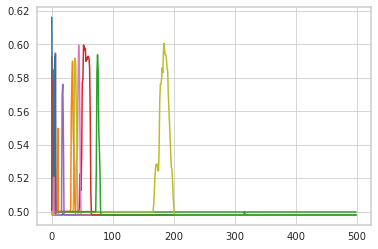

In [6]:
plot_analysis(analysis)
analysis.get_best_config(metric="mean_accuracy", mode="max", scope="last-10-avg")

# BrNet_CF_free

In [7]:
c = CI.confounder()
model = Models.Br_Net_CF_free(alpha=None)
search_space["model"] = model
search_space["wandb"]["group"] = "BrNet CF free"

c.generate_data(mode="br_net", samples=512, overlap=0, target_domain_samples=target_domain_samples, target_domain_confounding=1, train_confounding=1, test_confounding=[1], de_correlate_confounder_target=True, de_correlate_confounder_test=True, params=params)

reporter = CLIReporter(max_progress_rows=1, max_report_frequency=120)
analysis = tune.run(c.train_tune,num_samples=samples, progress_reporter=reporter, config=search_space, scheduler=ASHAScheduler(metric="mean_accuracy", mode="max", max_t=max_t))

2022-07-15 12:51:45,910	INFO registry.py:91 -- Detected unknown callable for trainable. Converting to class.
2022-07-15 12:51:48,779	WARNING worker.py:1404 -- Warning: The actor ImplicitFunc is very large (16 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
(ImplicitFunc pid=4074209) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin


== Status ==
Current time: 2022-07-15 12:51:55 (running for 00:00:09.39)
Memory usage on this node: 21.6/30.5 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 256.000: None | Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/7.03 GiB heap, 0.0/3.52 GiB objects
Result logdir: /home/raffi/ray_results/train_tune_2022-07-15_12-51-46
Number of trials: 17/30 (16 PENDING, 1 RUNNING)
+------------------------+----------+------------------------+----------+--------------+-----------+----------------+
| Trial name             | status   | loc                    |    alpha |   batch_size |        lr |   weight_decay |
|------------------------+----------+------------------------+----------+--------------+-----------+----------------|
| train_tune_1ede3_00000 | RUNNING  | 192.168.178.26:4074209 | 0.281227 |          128 | 0.0441387 |     0.00277457 |
| train_tune_1ede3_00001 | PENDING  |                        | 0.45186

(ImplicitFunc pid=4074209) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4074209) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-51-46/train_tune_1ede3_00000_0_alpha=0.2812,batch_size=128,lr=0.0441,weight_decay=0.0028_2022-07-15_12-51-48/wandb/run-20220715_125152-1ede3_00000
(ImplicitFunc pid=4074209) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=4074209) wandb: Syncing run train_tune_1ede3_00000
(ImplicitFunc pid=4074209) wandb: ⭐️ View project at https://wandb.ai/confounder_in_ml/Hyperparameters
(ImplicitFunc pid=4074209) wandb: 🚀 View run at https://wandb.ai/confounder_in_ml/Hyperparameters/runs/1ede3_00000


Result for train_tune_1ede3_00000:
  date: 2022-07-15_12-51-55
  done: false
  experiment_id: 834433d542bb4a6a8d7ea8598bf0c562
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4074209
  time_since_restore: 0.23795866966247559
  time_this_iter_s: 0.23795866966247559
  time_total_s: 0.23795866966247559
  timestamp: 1657882315
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1ede3_00000
  warmup_time: 3.8865957260131836
  


(ImplicitFunc pid=4074328) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin
(ImplicitFunc pid=4074326) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin


Result for train_tune_1ede3_00000:
  date: 2022-07-15_12-52-03
  done: false
  experiment_id: 834433d542bb4a6a8d7ea8598bf0c562
  hostname: fedora
  iterations_since_restore: 15
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4074209
  time_since_restore: 8.182455062866211
  time_this_iter_s: 0.3300795555114746
  time_total_s: 8.182455062866211
  timestamp: 1657882323
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 1ede3_00000
  warmup_time: 3.8865957260131836
  


(ImplicitFunc pid=4074333) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin
(ImplicitFunc pid=4074330) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin
(ImplicitFunc pid=4074331) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin
(ImplicitFunc pid=4074338) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin
(ImplicitFunc pid=4074336) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin
(ImplicitFunc pid=4074356) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin
(ImplicitFunc pid=4074367) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin
(ImplicitFunc pid=4074394) wandb: Currently logg

Result for train_tune_1ede3_00000:
  date: 2022-07-15_12-52-08
  done: false
  experiment_id: 834433d542bb4a6a8d7ea8598bf0c562
  hostname: fedora
  iterations_since_restore: 36
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4074209
  time_since_restore: 13.470121145248413
  time_this_iter_s: 0.47705554962158203
  time_total_s: 13.470121145248413
  timestamp: 1657882328
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 1ede3_00000
  warmup_time: 3.8865957260131836
  


(ImplicitFunc pid=4074328) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4074328) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-51-46/train_tune_1ede3_00002_2_alpha=0.8288,batch_size=256,lr=0.0454,weight_decay=0.0020_2022-07-15_12-51-55/wandb/run-20220715_125203-1ede3_00002
(ImplicitFunc pid=4074328) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=4074328) wandb: Syncing run train_tune_1ede3_00002
(ImplicitFunc pid=4074328) wandb: ⭐️ View project at https://wandb.ai/confounder_in_ml/Hyperparameters
(ImplicitFunc pid=4074328) wandb: 🚀 View run at https://wandb.ai/confounder_in_ml/Hyperparameters/runs/1ede3_00002
(ImplicitFunc pid=4074326) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4074326) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-51-46/train_tune_1ede3_00001_1_alpha=0.4519,batch_size=256,lr=0.0013,weight_decay=0.0000_2022-07-15_12-51-55/wandb/run-

Result for train_tune_1ede3_00002:
  date: 2022-07-15_12-52-09
  done: false
  experiment_id: 6ff50c5afe0b4aec8039d16732da0252
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4074328
  time_since_restore: 0.43163323402404785
  time_this_iter_s: 0.43163323402404785
  time_total_s: 0.43163323402404785
  timestamp: 1657882329
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1ede3_00002
  warmup_time: 6.204499006271362
  
Result for train_tune_1ede3_00001:
  date: 2022-07-15_12-52-09
  done: false
  experiment_id: c4ee9a14160c43eb9c4fe7360100662a
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4074326
  time_since_restore: 0.4784727096557617
  time_this_iter_s: 0.4784727096557617
  time_total_s: 0.4784727096557617
  timestamp: 1657882329
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1ede3_00001
  warmup_time: 6.334338426589966
  


(ImplicitFunc pid=4074333) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4074333) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-51-46/train_tune_1ede3_00005_5_alpha=0.5193,batch_size=64,lr=0.0382,weight_decay=0.0008_2022-07-15_12-51-56/wandb/run-20220715_125204-1ede3_00005
(ImplicitFunc pid=4074333) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=4074333) wandb: Syncing run train_tune_1ede3_00005
(ImplicitFunc pid=4074333) wandb: ⭐️ View project at https://wandb.ai/confounder_in_ml/Hyperparameters
(ImplicitFunc pid=4074333) wandb: 🚀 View run at https://wandb.ai/confounder_in_ml/Hyperparameters/runs/1ede3_00005
(ImplicitFunc pid=4074330) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4074330) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-51-46/train_tune_1ede3_00003_3_alpha=0.6351,batch_size=256,lr=0.0001,weight_decay=0.0040_2022-07-15_12-51-55/wandb/run-2

Result for train_tune_1ede3_00005:
  date: 2022-07-15_12-52-11
  done: false
  experiment_id: da37a30032934be2a3f14d0c398988ee
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4074333
  time_since_restore: 0.5682699680328369
  time_this_iter_s: 0.5682699680328369
  time_total_s: 0.5682699680328369
  timestamp: 1657882331
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1ede3_00005
  warmup_time: 7.389736890792847
  
Result for train_tune_1ede3_00003:
  date: 2022-07-15_12-52-11
  done: false
  experiment_id: 31466834f39945b7a7752e62915c3966
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4074330
  time_since_restore: 0.47656941413879395
  time_this_iter_s: 0.47656941413879395
  time_total_s: 0.47656941413879395
  timestamp: 1657882331
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1ede3_00003
  warmup_time: 7.494507312774658
  


(ImplicitFunc pid=4074338) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4074338) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-51-46/train_tune_1ede3_00007_7_alpha=0.5286,batch_size=128,lr=0.0015,weight_decay=0.0038_2022-07-15_12-51-56/wandb/run-20220715_125205-1ede3_00007
(ImplicitFunc pid=4074338) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=4074338) wandb: Syncing run train_tune_1ede3_00007
(ImplicitFunc pid=4074338) wandb: ⭐️ View project at https://wandb.ai/confounder_in_ml/Hyperparameters
(ImplicitFunc pid=4074338) wandb: 🚀 View run at https://wandb.ai/confounder_in_ml/Hyperparameters/runs/1ede3_00007
(ImplicitFunc pid=4074336) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4074336) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-51-46/train_tune_1ede3_00006_6_alpha=0.9238,batch_size=128,lr=0.0001,weight_decay=0.0032_2022-07-15_12-51-56/wandb/run-

Result for train_tune_1ede3_00007:
  date: 2022-07-15_12-52-12
  done: false
  experiment_id: 78199d9fd39e4345969dc681efd87479
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4074338
  time_since_restore: 0.5764811038970947
  time_this_iter_s: 0.5764811038970947
  time_total_s: 0.5764811038970947
  timestamp: 1657882332
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1ede3_00007
  warmup_time: 7.915521860122681
  
Result for train_tune_1ede3_00006:
  date: 2022-07-15_12-52-12
  done: false
  experiment_id: b56ae9c40ceb49a39c0cd9bbf227f3f3
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4074336
  time_since_restore: 0.7979340553283691
  time_this_iter_s: 0.7979340553283691
  time_total_s: 0.7979340553283691
  timestamp: 1657882332
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1ede3_00006
  warmup_time: 7.636778354644775
  


(ImplicitFunc pid=4074367) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4074367) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-51-46/train_tune_1ede3_00009_9_alpha=0.8239,batch_size=128,lr=0.0010,weight_decay=0.0026_2022-07-15_12-51-57/wandb/run-20220715_125205-1ede3_00009
(ImplicitFunc pid=4074367) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=4074367) wandb: Syncing run train_tune_1ede3_00009
(ImplicitFunc pid=4074367) wandb: ⭐️ View project at https://wandb.ai/confounder_in_ml/Hyperparameters
(ImplicitFunc pid=4074367) wandb: 🚀 View run at https://wandb.ai/confounder_in_ml/Hyperparameters/runs/1ede3_00009
(ImplicitFunc pid=4074397) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4074397) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-51-46/train_tune_1ede3_00011_11_alpha=0.8131,batch_size=256,lr=0.0008,weight_decay=0.0101_2022-07-15_12-51-57/wandb/run

Result for train_tune_1ede3_00004:
  date: 2022-07-15_12-52-12
  done: false
  experiment_id: 01362f616b9c41728b6b34da13cc1e55
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4074331
  time_since_restore: 1.346691370010376
  time_this_iter_s: 1.346691370010376
  time_total_s: 1.346691370010376
  timestamp: 1657882332
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1ede3_00004
  warmup_time: 7.682568550109863
  
Result for train_tune_1ede3_00008:
  date: 2022-07-15_12-52-13
  done: false
  experiment_id: 346fda41dd6942379683bcf1cc3f3b2e
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4074356
  time_since_restore: 1.0280990600585938
  time_this_iter_s: 1.0280990600585938
  time_total_s: 1.0280990600585938
  timestamp: 1657882333
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1ede3_00008
  warmup_time: 7.483576536178589
  


(ImplicitFunc pid=4074525) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4074525) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-51-46/train_tune_1ede3_00015_15_alpha=0.5141,batch_size=128,lr=0.0004,weight_decay=0.0000_2022-07-15_12-51-58/wandb/run-20220715_125206-1ede3_00015
(ImplicitFunc pid=4074525) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=4074525) wandb: Syncing run train_tune_1ede3_00015
(ImplicitFunc pid=4074525) wandb: ⭐️ View project at https://wandb.ai/confounder_in_ml/Hyperparameters
(ImplicitFunc pid=4074525) wandb: 🚀 View run at https://wandb.ai/confounder_in_ml/Hyperparameters/runs/1ede3_00015
(ImplicitFunc pid=4074480) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4074498) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4074498) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-51-46/train_tune_1ede3_00014_14_alpha=0.5487

Result for train_tune_1ede3_00009:
  date: 2022-07-15_12-52-13
  done: false
  experiment_id: 5eb918e14e774f78aac8d4bd97126542
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4074367
  time_since_restore: 0.6202983856201172
  time_this_iter_s: 0.6202983856201172
  time_total_s: 0.6202983856201172
  timestamp: 1657882333
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1ede3_00009
  warmup_time: 7.987875461578369
  
Result for train_tune_1ede3_00011:
  date: 2022-07-15_12-52-13
  done: false
  experiment_id: 075ed09c5af741309faa079c5b1cc971
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4074397
  time_since_restore: 0.7563951015472412
  time_this_iter_s: 0.7563951015472412
  time_total_s: 0.7563951015472412
  timestamp: 1657882333
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1ede3_00011
  warmup_time: 7.716796159744263
  
Result for train_tun

(train_tune pid=4074394) wandb: Waiting for W&B process to finish... (success).
(train_tune pid=4074394) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4074394) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)


Result for train_tune_1ede3_00026:
  date: 2022-07-15_12-52-23
  done: false
  experiment_id: d476008951b24fa4bfd0bd55fce3e745
  hostname: fedora
  iterations_since_restore: 13
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4074413
  time_since_restore: 5.971613168716431
  time_this_iter_s: 0.4064350128173828
  time_total_s: 5.971613168716431
  timestamp: 1657882343
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 1ede3_00026
  warmup_time: 7.748347997665405
  
Result for train_tune_1ede3_00027:
  date: 2022-07-15_12-52-23
  done: false
  experiment_id: 31466834f39945b7a7752e62915c3966
  hostname: fedora
  iterations_since_restore: 12
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4074330
  time_since_restore: 5.8678061962127686
  time_this_iter_s: 0.3315582275390625
  time_total_s: 5.8678061962127686
  timestamp: 1657882343
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 1ede3_00027
  warmup_time: 7.494507312774658
  
Result for

(train_tune pid=4074394) wandb: | 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4074394) wandb: / 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074394) wandb: - 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074394) wandb: \ 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)


Result for train_tune_1ede3_00026:
  date: 2022-07-15_12-52-24
  done: true
  experiment_id: d476008951b24fa4bfd0bd55fce3e745
  hostname: fedora
  iterations_since_restore: 16
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4074413
  time_since_restore: 7.166470050811768
  time_this_iter_s: 0.451784610748291
  time_total_s: 7.166470050811768
  timestamp: 1657882344
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 1ede3_00026
  warmup_time: 7.748347997665405
  


(train_tune pid=4074394) wandb: | 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074394) wandb: / 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074394) wandb: - 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)


Result for train_tune_1ede3_00000:
  date: 2022-07-15_12-52-24
  done: false
  experiment_id: 834433d542bb4a6a8d7ea8598bf0c562
  hostname: fedora
  iterations_since_restore: 65
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4074209
  time_since_restore: 29.032331943511963
  time_this_iter_s: 0.2870461940765381
  time_total_s: 29.032331943511963
  timestamp: 1657882344
  timesteps_since_restore: 0
  training_iteration: 65
  trial_id: 1ede3_00000
  warmup_time: 3.8865957260131836
  


(train_tune pid=4074394) wandb: \ 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074394) wandb: | 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074394) wandb: / 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074394) wandb: - 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)


Result for train_tune_1ede3_00002:
  date: 2022-07-15_12-52-24
  done: false
  experiment_id: 6ff50c5afe0b4aec8039d16732da0252
  hostname: fedora
  iterations_since_restore: 35
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4074328
  time_since_restore: 15.921143293380737
  time_this_iter_s: 0.28928041458129883
  time_total_s: 15.921143293380737
  timestamp: 1657882344
  timesteps_since_restore: 0
  training_iteration: 35
  trial_id: 1ede3_00002
  warmup_time: 6.204499006271362
  


(train_tune pid=4074394) wandb: \ 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074525) wandb: Waiting for W&B process to finish... (success).
(train_tune pid=4074525) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
wandb:                                                                                 deduped)
(train_tune pid=4074525) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4074356) wandb: Waiting for W&B process to finish... (success).
(train_tune pid=4074356) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)


Result for train_tune_1ede3_00018:
  date: 2022-07-15_12-52-26
  done: false
  experiment_id: 5eb918e14e774f78aac8d4bd97126542
  hostname: fedora
  iterations_since_restore: 25
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4074367
  time_since_restore: 10.715737104415894
  time_this_iter_s: 0.24640989303588867
  time_total_s: 10.715737104415894
  timestamp: 1657882346
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: 1ede3_00018
  warmup_time: 7.987875461578369
  


(train_tune pid=4074356) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4074525) wandb: | 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074356) wandb: | 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074525) wandb: / 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074356) wandb: / 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074525) wandb: - 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074356) wandb: - 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074356) wandb: \ 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074413) wandb: Waiting for W&B process to finish... (success).
(train_tune pid=4074413) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4074525) wandb: \ 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074356) wandb: | 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_

Result for train_tune_1ede3_00021:
  date: 2022-07-15_12-52-27
  done: false
  experiment_id: 075ed09c5af741309faa079c5b1cc971
  hostname: fedora
  iterations_since_restore: 26
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4074397
  time_since_restore: 11.05946135520935
  time_this_iter_s: 0.313798189163208
  time_total_s: 11.05946135520935
  timestamp: 1657882347
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 1ede3_00021
  warmup_time: 7.716796159744263
  


(train_tune pid=4074356) wandb: - 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
wandb: \ 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)f 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074356) wandb: \ 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074525) wandb: | 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)


Result for train_tune_1ede3_00005:
  date: 2022-07-15_12-52-27
  done: false
  experiment_id: da37a30032934be2a3f14d0c398988ee
  hostname: fedora
  iterations_since_restore: 30
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4074333
  time_since_restore: 16.133327960968018
  time_this_iter_s: 0.31807518005371094
  time_total_s: 16.133327960968018
  timestamp: 1657882347
  timesteps_since_restore: 0
  training_iteration: 30
  trial_id: 1ede3_00005
  warmup_time: 7.389736890792847
  


(train_tune pid=4074356) wandb: | 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074525) wandb: / 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074356) wandb: / 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074413) wandb: | 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4074525) wandb: - 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)


Result for train_tune_1ede3_00024:
  date: 2022-07-15_12-52-27
  done: false
  experiment_id: 01362f616b9c41728b6b34da13cc1e55
  hostname: fedora
  iterations_since_restore: 20
  mean_accuracy: 0.5029296875
  node_ip: 192.168.178.26
  pid: 4074331
  time_since_restore: 11.203763723373413
  time_this_iter_s: 0.3914940357208252
  time_total_s: 11.203763723373413
  timestamp: 1657882347
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 1ede3_00024
  warmup_time: 7.682568550109863
  


(train_tune pid=4074525) wandb: \ 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074356) wandb: - 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074413) wandb: / 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074413) wandb: - 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)


Result for train_tune_1ede3_00027:
  date: 2022-07-15_12-52-28
  done: false
  experiment_id: 31466834f39945b7a7752e62915c3966
  hostname: fedora
  iterations_since_restore: 29
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4074330
  time_since_restore: 11.082032918930054
  time_this_iter_s: 0.29067063331604004
  time_total_s: 11.082032918930054
  timestamp: 1657882348
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: 1ede3_00027
  warmup_time: 7.494507312774658
  


(train_tune pid=4074413) wandb: \ 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074413) wandb: | 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
wandb:                                                                                 deduped)
(train_tune pid=4074413) wandb: / 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
wandb:                                                                                 deduped)
(train_tune pid=4074413) wandb: - 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074413) wandb: \ 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074413) wandb: | 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074413) wandb: / 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074413) wandb: - 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074413) wandb: \ 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074413) wandb: | 0.013 MB of 0.013 MB upload

Result for train_tune_1ede3_00000:
  date: 2022-07-15_12-52-29
  done: false
  experiment_id: 834433d542bb4a6a8d7ea8598bf0c562
  hostname: fedora
  iterations_since_restore: 84
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4074209
  time_since_restore: 34.155712842941284
  time_this_iter_s: 0.268399715423584
  time_total_s: 34.155712842941284
  timestamp: 1657882349
  timesteps_since_restore: 0
  training_iteration: 84
  trial_id: 1ede3_00000
  warmup_time: 3.8865957260131836
  


(train_tune pid=4074356) wandb: 
(train_tune pid=4074356) wandb: Run history:
(train_tune pid=4074356) wandb: classification_accuracy ▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁
(train_tune pid=4074356) wandb:     confounder_accuracy ▁▁▁▁▁▁▄███████████
(train_tune pid=4074356) wandb: 
(train_tune pid=4074356) wandb: Run summary:
(train_tune pid=4074356) wandb: classification_accuracy 0.49805
(train_tune pid=4074356) wandb:     confounder_accuracy 1.0
(train_tune pid=4074356) wandb: 
(train_tune pid=4074356) wandb: Synced train_tune_1ede3_00008: https://wandb.ai/confounder_in_ml/Hyperparameters/runs/1ede3_00008
(train_tune pid=4074356) wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
(train_tune pid=4074356) wandb: Find logs at: /home/raffi/ray_results/train_tune_2022-07-15_12-51-46/train_tune_1ede3_00008_8_alpha=0.5512,batch_size=128,lr=0.0001,weight_decay=0.0001_2022-07-15_12-51-56/wandb/run-20220715_125205-1ede3_00008/logs


Result for train_tune_1ede3_00002:
  date: 2022-07-15_12-52-30
  done: false
  experiment_id: 6ff50c5afe0b4aec8039d16732da0252
  hostname: fedora
  iterations_since_restore: 53
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4074328
  time_since_restore: 21.0911967754364
  time_this_iter_s: 0.2676565647125244
  time_total_s: 21.0911967754364
  timestamp: 1657882350
  timesteps_since_restore: 0
  training_iteration: 53
  trial_id: 1ede3_00002
  warmup_time: 6.204499006271362
  


wandb:                                                                                 deduped)


Result for train_tune_1ede3_00018:
  date: 2022-07-15_12-52-31
  done: false
  experiment_id: 5eb918e14e774f78aac8d4bd97126542
  hostname: fedora
  iterations_since_restore: 42
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4074367
  time_since_restore: 15.770163536071777
  time_this_iter_s: 0.2628295421600342
  time_total_s: 15.770163536071777
  timestamp: 1657882351
  timesteps_since_restore: 0
  training_iteration: 42
  trial_id: 1ede3_00018
  warmup_time: 7.987875461578369
  


(train_tune pid=4074413) wandb: 
(train_tune pid=4074413) wandb: Run history:
(train_tune pid=4074413) wandb: classification_accuracy ▁▁▁▁▁█▁▆▁▁▁▁▁▁▁▁▁▁
(train_tune pid=4074413) wandb:     confounder_accuracy ▁▁▁▁▁▅▁▃██████████
(train_tune pid=4074413) wandb: 
(train_tune pid=4074413) wandb: Run summary:
(train_tune pid=4074413) wandb: classification_accuracy 0.49805
(train_tune pid=4074413) wandb:     confounder_accuracy 1.0
(train_tune pid=4074413) wandb: 
(train_tune pid=4074413) wandb: Synced train_tune_1ede3_00012: https://wandb.ai/confounder_in_ml/Hyperparameters/runs/1ede3_00012
(train_tune pid=4074413) wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
(train_tune pid=4074413) wandb: Find logs at: /home/raffi/ray_results/train_tune_2022-07-15_12-51-46/train_tune_1ede3_00012_12_alpha=0.3260,batch_size=32,lr=0.0001,weight_decay=0.0916_2022-07-15_12-51-57/wandb/run-20220715_125206-1ede3_00012/logs


Result for train_tune_1ede3_00021:
  date: 2022-07-15_12-52-32
  done: false
  experiment_id: 075ed09c5af741309faa079c5b1cc971
  hostname: fedora
  iterations_since_restore: 42
  mean_accuracy: 0.54296875
  node_ip: 192.168.178.26
  pid: 4074397
  time_since_restore: 16.16023850440979
  time_this_iter_s: 0.38535070419311523
  time_total_s: 16.16023850440979
  timestamp: 1657882352
  timesteps_since_restore: 0
  training_iteration: 42
  trial_id: 1ede3_00021
  warmup_time: 7.716796159744263
  
Result for train_tune_1ede3_00005:
  date: 2022-07-15_12-52-32
  done: false
  experiment_id: da37a30032934be2a3f14d0c398988ee
  hostname: fedora
  iterations_since_restore: 46
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4074333
  time_since_restore: 21.321604013442993
  time_this_iter_s: 0.29962754249572754
  time_total_s: 21.321604013442993
  timestamp: 1657882352
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 1ede3_00005
  warmup_time: 7.389736890792847
  
R

(train_tune pid=4074397) wandb: Waiting for W&B process to finish... (success).
(train_tune pid=4074397) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4074397) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)


Result for train_tune_1ede3_00005:
  date: 2022-07-15_12-52-42
  done: false
  experiment_id: da37a30032934be2a3f14d0c398988ee
  hostname: fedora
  iterations_since_restore: 78
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4074333
  time_since_restore: 31.69396162033081
  time_this_iter_s: 0.2858729362487793
  time_total_s: 31.69396162033081
  timestamp: 1657882362
  timesteps_since_restore: 0
  training_iteration: 78
  trial_id: 1ede3_00005
  warmup_time: 7.389736890792847
  


2022-07-15 12:52:43,223	WARNING tune.py:682 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
(train_tune pid=4074397) wandb: | 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074397) wandb: / 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)


== Status ==
Current time: 2022-07-15 12:52:43 (running for 00:00:57.19)
Memory usage on this node: 24.7/30.5 GiB
Using AsyncHyperBand: num_stopped=24
Bracket: Iter 256.000: None | Iter 64.000: 0.5 | Iter 16.000: 0.5 | Iter 4.000: 0.5 | Iter 1.000: 0.5
Resources requested: 6.0/16 CPUs, 0/0 GPUs, 0.0/7.03 GiB heap, 0.0/3.52 GiB objects
Result logdir: /home/raffi/ray_results/train_tune_2022-07-15_12-51-46
Number of trials: 30/30 (6 RUNNING, 24 TERMINATED)
+------------------------+------------+------------------------+-----------+--------------+-------------+----------------+----------+--------+------------------+
| Trial name             | status     | loc                    |     alpha |   batch_size |          lr |   weight_decay |      acc |   iter |   total time (s) |
|------------------------+------------+------------------------+-----------+--------------+-------------+----------------+----------+--------+------------------|
| train_tune_1ede3_00000 | RUNNING    | 192.168.178.26:4

(train_tune pid=4074397) wandb: - 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074397) wandb: \ 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074397) wandb: | 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074397) wandb: / 0.010 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074397) wandb: - 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074397) wandb: \ 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074397) wandb: | 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074397) wandb: / 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074397) wandb: - 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074397) wandb: \ 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4074397) wandb: | 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
wandb:                                                                                 

{'model': Br_Net_CF_free(
   (linear_relu_stack): Sequential(
     (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
     (1): Tanh()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1))
     (4): Tanh()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
     (7): Tanh()
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (9): Flatten(start_dim=1, end_dim=-1)
   )
   (class_predictor): Sequential(
     (0): Linear(in_features=32, out_features=2, bias=True)
   )
   (domain_predictor): Sequential(
     (0): Linear(in_features=32, out_features=2, bias=True)
   )
 ),
 'device': 'cuda',
 'loss_fn': CrossEntropyLoss(),
 'epochs': 500,
 'batch_size': 128,
 'optimizer': torch.optim.adam.Adam,
 'alpha': 0.5285755689032852,
 'lr': 0.001458905356239198,
 'weight_decay': 0.00378

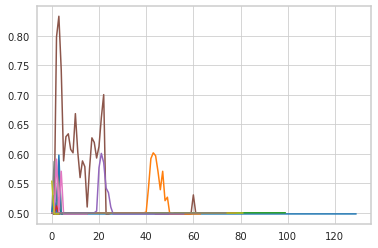

In [8]:
plot_analysis(analysis)
analysis.get_best_config(metric="mean_accuracy", mode="max", scope="last-10-avg")

# BrNet_CF_free_conditioned

In [ ]:
c = CI.confounder()
model = Models.Br_Net_CF_free(alpha=None)
search_space["model"] = model
search_space["wandb"]["group"] = "BrNet CF free conditioned"

c.generate_data(mode="br_net", samples=512, overlap=0, target_domain_samples=target_domain_samples, target_domain_confounding=1, train_confounding=1, test_confounding=[1], de_correlate_confounder_target=True, de_correlate_confounder_test=True, params=params, conditioning=0)

reporter = CLIReporter(max_progress_rows=1, max_report_frequency=120)
analysis = tune.run(c.train_tune,num_samples=samples, progress_reporter=reporter, config=search_space, scheduler=ASHAScheduler(metric="mean_accuracy", mode="max", max_t=max_t))

2022-07-15 12:52:47,933	INFO registry.py:91 -- Detected unknown callable for trainable. Converting to class.
2022-07-15 12:52:51,139	WARNING worker.py:1404 -- Warning: The actor ImplicitFunc is very large (16 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
(ImplicitFunc pid=4076062) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin


== Status ==
Current time: 2022-07-15 12:52:59 (running for 00:00:11.13)
Memory usage on this node: 21.7/30.5 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 256.000: None | Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/7.03 GiB heap, 0.0/3.52 GiB objects
Result logdir: /home/raffi/ray_results/train_tune_2022-07-15_12-52-48
Number of trials: 17/30 (16 PENDING, 1 RUNNING)
+------------------------+----------+------------------------+----------+--------------+-----------+----------------+
| Trial name             | status   | loc                    |    alpha |   batch_size |        lr |   weight_decay |
|------------------------+----------+------------------------+----------+--------------+-----------+----------------|
| train_tune_43d7f_00000 | RUNNING  | 192.168.178.26:4076062 | 0.281227 |          128 | 0.0441387 |     0.00277457 |
| train_tune_43d7f_00001 | PENDING  |                        | 0.45186

(ImplicitFunc pid=4076062) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4076062) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-52-48/train_tune_43d7f_00000_0_alpha=0.2812,batch_size=128,lr=0.0441,weight_decay=0.0028_2022-07-15_12-52-50/wandb/run-20220715_125255-43d7f_00000
(ImplicitFunc pid=4076062) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=4076062) wandb: Syncing run train_tune_43d7f_00000
(ImplicitFunc pid=4076062) wandb: ⭐️ View project at https://wandb.ai/confounder_in_ml/Hyperparameters
(ImplicitFunc pid=4076062) wandb: 🚀 View run at https://wandb.ai/confounder_in_ml/Hyperparameters/runs/43d7f_00000


Result for train_tune_43d7f_00000:
  date: 2022-07-15_12-52-59
  done: false
  experiment_id: b874b30e7ad04944bf4bf2f03eac01da
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.51171875
  node_ip: 192.168.178.26
  pid: 4076062
  time_since_restore: 0.17058110237121582
  time_this_iter_s: 0.17058110237121582
  time_total_s: 0.17058110237121582
  timestamp: 1657882379
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 43d7f_00000
  warmup_time: 4.780487775802612
  
Result for train_tune_43d7f_00000:
  date: 2022-07-15_12-53-06
  done: false
  experiment_id: b874b30e7ad04944bf4bf2f03eac01da
  hostname: fedora
  iterations_since_restore: 13
  mean_accuracy: 0.5322265625
  node_ip: 192.168.178.26
  pid: 4076062
  time_since_restore: 7.668237686157227
  time_this_iter_s: 0.40470314025878906
  time_total_s: 7.668237686157227
  timestamp: 1657882386
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 43d7f_00000
  warmup_time: 4.780487775802612
  


(ImplicitFunc pid=4076243) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin
(ImplicitFunc pid=4076241) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin
(ImplicitFunc pid=4076245) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin
(ImplicitFunc pid=4076247) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin
(ImplicitFunc pid=4076249) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin
(ImplicitFunc pid=4076251) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin
(ImplicitFunc pid=4076253) wandb: Currently logged in as: raphaelmaser (confounder_in_ml). Use `wandb login --relogin` to force relogin
(ImplicitFunc pid=4076257) wandb: Currently logg

Result for train_tune_43d7f_00000:
  date: 2022-07-15_12-53-12
  done: false
  experiment_id: b874b30e7ad04944bf4bf2f03eac01da
  hostname: fedora
  iterations_since_restore: 29
  mean_accuracy: 0.6455078125
  node_ip: 192.168.178.26
  pid: 4076062
  time_since_restore: 12.70747685432434
  time_this_iter_s: 0.3280797004699707
  time_total_s: 12.70747685432434
  timestamp: 1657882392
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: 43d7f_00000
  warmup_time: 4.780487775802612
  


(ImplicitFunc pid=4076241) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4076241) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-52-48/train_tune_43d7f_00001_1_alpha=0.4519,batch_size=256,lr=0.0013,weight_decay=0.0000_2022-07-15_12-52-59/wandb/run-20220715_125308-43d7f_00001
(ImplicitFunc pid=4076241) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=4076241) wandb: Syncing run train_tune_43d7f_00001
(ImplicitFunc pid=4076241) wandb: ⭐️ View project at https://wandb.ai/confounder_in_ml/Hyperparameters
(ImplicitFunc pid=4076241) wandb: 🚀 View run at https://wandb.ai/confounder_in_ml/Hyperparameters/runs/43d7f_00001
(ImplicitFunc pid=4076243) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4076243) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-52-48/train_tune_43d7f_00002_2_alpha=0.8288,batch_size=256,lr=0.0454,weight_decay=0.0020_2022-07-15_12-52-59/wandb/run-

Result for train_tune_43d7f_00002:
  date: 2022-07-15_12-53-14
  done: true
  experiment_id: 012af08109fe48f79e57fd2701d6365a
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4076243
  time_since_restore: 0.6533501148223877
  time_this_iter_s: 0.6533501148223877
  time_total_s: 0.6533501148223877
  timestamp: 1657882394
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 43d7f_00002
  warmup_time: 6.587104797363281
  
Result for train_tune_43d7f_00003:
  date: 2022-07-15_12-53-15
  done: true
  experiment_id: fd89e17b131d4504bb31c91c6a3c9fcc
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4076245
  time_since_restore: 0.70245361328125
  time_this_iter_s: 0.70245361328125
  time_total_s: 0.70245361328125
  timestamp: 1657882395
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 43d7f_00003
  warmup_time: 6.548598527908325
  
Result for train_tune_43d7f_

(ImplicitFunc pid=4076249) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4076249) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-52-48/train_tune_43d7f_00005_5_alpha=0.5193,batch_size=64,lr=0.0382,weight_decay=0.0008_2022-07-15_12-52-59/wandb/run-20220715_125309-43d7f_00005
(ImplicitFunc pid=4076249) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=4076249) wandb: Syncing run train_tune_43d7f_00005
(ImplicitFunc pid=4076249) wandb: ⭐️ View project at https://wandb.ai/confounder_in_ml/Hyperparameters
(ImplicitFunc pid=4076249) wandb: 🚀 View run at https://wandb.ai/confounder_in_ml/Hyperparameters/runs/43d7f_00005
(ImplicitFunc pid=4076251) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4076251) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-52-48/train_tune_43d7f_00006_6_alpha=0.9238,batch_size=128,lr=0.0001,weight_decay=0.0032_2022-07-15_12-53-00/wandb/run-2

Result for train_tune_43d7f_00020:
  date: 2022-07-15_12-53-16
  done: false
  experiment_id: fd89e17b131d4504bb31c91c6a3c9fcc
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4076245
  time_since_restore: 0.896247148513794
  time_this_iter_s: 0.896247148513794
  time_total_s: 0.896247148513794
  timestamp: 1657882396
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 43d7f_00020
  warmup_time: 6.548598527908325
  
Result for train_tune_43d7f_00019:
  date: 2022-07-15_12-53-16
  done: true
  experiment_id: 012af08109fe48f79e57fd2701d6365a
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4076243
  time_since_restore: 1.1001319885253906
  time_this_iter_s: 1.1001319885253906
  time_total_s: 1.1001319885253906
  timestamp: 1657882396
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 43d7f_00019
  warmup_time: 6.587104797363281
  
Result for train

(ImplicitFunc pid=4076257) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4076257) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-52-48/train_tune_43d7f_00009_9_alpha=0.8239,batch_size=128,lr=0.0010,weight_decay=0.0026_2022-07-15_12-53-00/wandb/run-20220715_125310-43d7f_00009
(ImplicitFunc pid=4076257) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=4076257) wandb: Syncing run train_tune_43d7f_00009
(ImplicitFunc pid=4076257) wandb: ⭐️ View project at https://wandb.ai/confounder_in_ml/Hyperparameters
(ImplicitFunc pid=4076257) wandb: 🚀 View run at https://wandb.ai/confounder_in_ml/Hyperparameters/runs/43d7f_00009
(ImplicitFunc pid=4076255) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4076255) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-52-48/train_tune_43d7f_00008_8_alpha=0.5512,batch_size=128,lr=0.0001,weight_decay=0.0001_2022-07-15_12-53-00/wandb/run-

Result for train_tune_43d7f_00021:
  date: 2022-07-15_12-53-17
  done: false
  experiment_id: 012af08109fe48f79e57fd2701d6365a
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4076243
  time_since_restore: 0.5978224277496338
  time_this_iter_s: 0.5978224277496338
  time_total_s: 0.5978224277496338
  timestamp: 1657882397
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 43d7f_00021
  warmup_time: 6.587104797363281
  
Result for train_tune_43d7f_00018:
  date: 2022-07-15_12-53-17
  done: true
  experiment_id: 485bb8b3fec147759167a34f5ad9b245
  hostname: fedora
  iterations_since_restore: 4
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4076241
  time_since_restore: 2.3821463584899902
  time_this_iter_s: 0.4871511459350586
  time_total_s: 2.3821463584899902
  timestamp: 1657882397
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 43d7f_00018
  warmup_time: 6.636091232299805
  


(ImplicitFunc pid=4076298) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4076298) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-52-48/train_tune_43d7f_00010_10_alpha=0.0854,batch_size=32,lr=0.0007,weight_decay=0.0000_2022-07-15_12-53-00/wandb/run-20220715_125310-43d7f_00010
(ImplicitFunc pid=4076298) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=4076298) wandb: Syncing run train_tune_43d7f_00010
(ImplicitFunc pid=4076298) wandb: ⭐️ View project at https://wandb.ai/confounder_in_ml/Hyperparameters
(ImplicitFunc pid=4076298) wandb: 🚀 View run at https://wandb.ai/confounder_in_ml/Hyperparameters/runs/43d7f_00010
(ImplicitFunc pid=4076326) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4076326) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-52-48/train_tune_43d7f_00011_11_alpha=0.8131,batch_size=256,lr=0.0008,weight_decay=0.0101_2022-07-15_12-53-00/wandb/run

Result for train_tune_43d7f_00009:
  date: 2022-07-15_12-53-18
  done: false
  experiment_id: df5dff34173f41e5aecce7e058965223
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4076257
  time_since_restore: 0.585167646408081
  time_this_iter_s: 0.585167646408081
  time_total_s: 0.585167646408081
  timestamp: 1657882398
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 43d7f_00009
  warmup_time: 8.08198070526123
  


(ImplicitFunc pid=4076357) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4076357) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-52-48/train_tune_43d7f_00013_13_alpha=0.3853,batch_size=32,lr=0.0005,weight_decay=0.0003_2022-07-15_12-53-01/wandb/run-20220715_125311-43d7f_00013
(ImplicitFunc pid=4076357) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=4076357) wandb: Syncing run train_tune_43d7f_00013
(ImplicitFunc pid=4076357) wandb: ⭐️ View project at https://wandb.ai/confounder_in_ml/Hyperparameters
(ImplicitFunc pid=4076357) wandb: 🚀 View run at https://wandb.ai/confounder_in_ml/Hyperparameters/runs/43d7f_00013


Result for train_tune_43d7f_00020:
  date: 2022-07-15_12-53-18
  done: true
  experiment_id: fd89e17b131d4504bb31c91c6a3c9fcc
  hostname: fedora
  iterations_since_restore: 4
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4076245
  time_since_restore: 2.674616575241089
  time_this_iter_s: 0.6470587253570557
  time_total_s: 2.674616575241089
  timestamp: 1657882398
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 43d7f_00020
  warmup_time: 6.548598527908325
  
Result for train_tune_43d7f_00008:
  date: 2022-07-15_12-53-18
  done: false
  experiment_id: 91610ba65e404d169f75c08913f48af7
  hostname: fedora
  iterations_since_restore: 1
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4076255
  time_since_restore: 1.0821561813354492
  time_this_iter_s: 1.0821561813354492
  time_total_s: 1.0821561813354492
  timestamp: 1657882398
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 43d7f_00008
  warmup_time: 7.979557752609253
  
Result for trai

(ImplicitFunc pid=4076381) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4076381) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-52-48/train_tune_43d7f_00014_14_alpha=0.5487,batch_size=32,lr=0.0002,weight_decay=0.0030_2022-07-15_12-53-01/wandb/run-20220715_125311-43d7f_00014
(ImplicitFunc pid=4076381) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=4076381) wandb: Syncing run train_tune_43d7f_00014
(ImplicitFunc pid=4076381) wandb: ⭐️ View project at https://wandb.ai/confounder_in_ml/Hyperparameters
(ImplicitFunc pid=4076381) wandb: 🚀 View run at https://wandb.ai/confounder_in_ml/Hyperparameters/runs/43d7f_00014
(ImplicitFunc pid=4076393) wandb: Tracking run with wandb version 0.12.21
(ImplicitFunc pid=4076393) wandb: Run data is saved locally in /home/raffi/ray_results/train_tune_2022-07-15_12-52-48/train_tune_43d7f_00015_15_alpha=0.5141,batch_size=128,lr=0.0004,weight_decay=0.0000_2022-07-15_12-53-01/wandb/run

Result for train_tune_43d7f_00004:
  date: 2022-07-15_12-53-18
  done: true
  experiment_id: 77ff5e41f43f4b90bd9eeb3bea7fae31
  hostname: fedora
  iterations_since_restore: 4
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4076247
  time_since_restore: 3.8170793056488037
  time_this_iter_s: 1.023350477218628
  time_total_s: 3.8170793056488037
  timestamp: 1657882398
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 43d7f_00004
  warmup_time: 6.817618370056152
  
Result for train_tune_43d7f_00007:
  date: 2022-07-15_12-53-18
  done: true
  experiment_id: 88d46fe5fec74d61ba644f5baff7dad4
  hostname: fedora
  iterations_since_restore: 4
  mean_accuracy: 0.50390625
  node_ip: 192.168.178.26
  pid: 4076253
  time_since_restore: 2.504101514816284
  time_this_iter_s: 0.8097684383392334
  time_total_s: 2.504101514816284
  timestamp: 1657882398
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 43d7f_00007
  warmup_time: 7.568766355514526
  
Result for train_t

(train_tune pid=4076298) wandb: Waiting for W&B process to finish... (success).
(train_tune pid=4076298) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)


Result for train_tune_43d7f_00014:
  date: 2022-07-15_12-53-25
  done: false
  experiment_id: cf68bf8ed6a74892b9235a4aa7db9e21
  hostname: fedora
  iterations_since_restore: 8
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4076381
  time_since_restore: 6.5239784717559814
  time_this_iter_s: 0.5383586883544922
  time_total_s: 6.5239784717559814
  timestamp: 1657882405
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 43d7f_00014
  warmup_time: 8.150432825088501
  


(train_tune pid=4076243) wandb: Waiting for W&B process to finish... (success).
(train_tune pid=4076243) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4076298) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)


Result for train_tune_43d7f_00026:
  date: 2022-07-15_12-53-25
  done: false
  experiment_id: fe8c517e613e4a6d874aab8e29c839e1
  hostname: fedora
  iterations_since_restore: 10
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4076249
  time_since_restore: 5.886985778808594
  time_this_iter_s: 0.3345372676849365
  time_total_s: 5.886985778808594
  timestamp: 1657882405
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 43d7f_00026
  warmup_time: 7.487240552902222
  
Result for train_tune_43d7f_00015:
  date: 2022-07-15_12-53-25
  done: false
  experiment_id: b05cba9ac05543c09b5106b2b7ba56ed
  hostname: fedora
  iterations_since_restore: 10
  mean_accuracy: 0.5927734375
  node_ip: 192.168.178.26
  pid: 4076393
  time_since_restore: 6.866902828216553
  time_this_iter_s: 0.2918565273284912
  time_total_s: 6.866902828216553
  timestamp: 1657882405
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 43d7f_00015
  warmup_time: 8.32726502418518
  
Resu

(train_tune pid=4076243) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4076357) wandb: Waiting for W&B process to finish... (success).
(train_tune pid=4076357) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(train_tune pid=4076243) wandb: | 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4076243) wandb: / 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)


Result for train_tune_43d7f_00022:
  date: 2022-07-15_12-53-26
  done: true
  experiment_id: 485bb8b3fec147759167a34f5ad9b245
  hostname: fedora
  iterations_since_restore: 16
  mean_accuracy: 0.5
  node_ip: 192.168.178.26
  pid: 4076241
  time_since_restore: 8.539006471633911
  time_this_iter_s: 0.28029513359069824
  time_total_s: 8.539006471633911
  timestamp: 1657882406
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 43d7f_00022
  warmup_time: 6.636091232299805
  


(train_tune pid=4076243) wandb: - 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4076298) wandb: | 0.001 MB of 0.003 MB uploaded (0.000 MB deduped)
(train_tune pid=4076243) wandb: \ 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4076298) wandb: / 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4076243) wandb: | 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4076243) wandb: / 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4076298) wandb: - 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4076243) wandb: - 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4076298) wandb: \ 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4076243) wandb: \ 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4076298) wandb: | 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4076298) wandb: / 0.001 MB of 0.013 MB uploaded (0.000 MB deduped)
(tra

Result for train_tune_43d7f_00011:
  date: 2022-07-15_12-53-26
  done: true
  experiment_id: c3335f7d379e4f718320a3841a9bc142
  hostname: fedora
  iterations_since_restore: 16
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4076326
  time_since_restore: 8.785053730010986
  time_this_iter_s: 0.29010558128356934
  time_total_s: 8.785053730010986
  timestamp: 1657882406
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 43d7f_00011
  warmup_time: 8.249494075775146
  


(train_tune pid=4076243) wandb: / 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4076298) wandb: \ 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4076298) wandb: | 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)


Result for train_tune_43d7f_00026:
  date: 2022-07-15_12-53-27
  done: true
  experiment_id: fe8c517e613e4a6d874aab8e29c839e1
  hostname: fedora
  iterations_since_restore: 16
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4076249
  time_since_restore: 7.660711765289307
  time_this_iter_s: 0.28853726387023926
  time_total_s: 7.660711765289307
  timestamp: 1657882407
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 43d7f_00026
  warmup_time: 7.487240552902222
  
Result for train_tune_43d7f_00015:
  date: 2022-07-15_12-53-27
  done: true
  experiment_id: b05cba9ac05543c09b5106b2b7ba56ed
  hostname: fedora
  iterations_since_restore: 16
  mean_accuracy: 0.498046875
  node_ip: 192.168.178.26
  pid: 4076393
  time_since_restore: 8.61474061012268
  time_this_iter_s: 0.29929614067077637
  time_total_s: 8.61474061012268
  timestamp: 1657882407
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 43d7f_00015
  warmup_time: 8.32726502418518
  


(train_tune pid=4076298) wandb: / 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)
(train_tune pid=4076298) wandb: - 0.013 MB of 0.013 MB uploaded (0.000 MB deduped)


In [ ]:
plot_analysis(analysis)
analysis.get_best_config(metric="mean_accuracy", mode="max", scope="last-10-avg")
#analysis.best_dataframe(metric="mean_accuracy", mode="max", scope="last-10-avg").plot()

# BrNet_DANN

In [ ]:
c = CI.confounder()
model = Models.Br_Net_DANN(alpha=None)
search_space["model"] = model
search_space["wandb"]["group"] = "BrNet DANN"

c.generate_data(mode="br_net", samples=512, overlap=0, target_domain_samples=target_domain_samples, target_domain_confounding=1, train_confounding=1, test_confounding=[1], de_correlate_confounder_target=True, de_correlate_confounder_test=True, params=params)

reporter = CLIReporter(max_progress_rows=1, max_report_frequency=120)
analysis = tune.run(c.train_tune,num_samples=samples, progress_reporter=reporter, config=search_space, scheduler=ASHAScheduler(metric="mean_accuracy", mode="max", max_t=max_t))

In [ ]:
plot_analysis(analysis)
analysis.get_best_config(metric="mean_accuracy", mode="max", scope="last-10-avg")